In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import missingno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sqlite3
from tqdm import tqdm

# Introduction
Battlefield 5 is a multiplayer first person shooter game developed by DICE and published by EA. It released on current generation Playstation and XBox consoles as well as PC in 2018. In this notebook, I determine whether the players can be segmented according to information about how they play the game. There are many ways one might segment the data in a rule-based fashion - according to platform, most played class, etc. Instead of doing this, I am interested in whether we can cluster players in some useful fashion according to various player metrics that are recorded and made available.

To do this, I scraped data off of [Battlefield Tracker](https://battlefieldtracker.com/). This comes with a caveat. While the game sold ar4ound 7.8 million copies, publicly available data only tracks about 1% of that. So in fact, this analysis really only tracks the top 10% of players snf dhoulf not be assumed to extend beyond that.

In [2]:
con = sqlite3.connect('bfvstats.db')
cur = con.cursor()

info = cur.execute('SELECT * FROM pragma_table_info("bfvstats");').fetchall() # column names (and other info)
query_cols = list(map(lambda x: x[1], info))[1:] # retrieve only names of columns I want to keep
query_cols = ','.join(query_cols)

df = pd.read_sql(f'SELECT {query_cols} FROM bfvstats;', con)
df = df.drop(df.columns[0], axis=1)
df.head()

con.close()

In [3]:
shape = df.shape
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns')

There are 73551 rows and 231 columns


There are many features. Given I simply dumped data from an API into a SQL database, and I suspect at least some features only took one unique value, I check to see if that is the case. Features taking only one value, whether NaN values or other values, are useless when applying machine learning methods, since they do not distinguish any sample from any other sample. This does not make such features useless per se (ex. suppose you learned everyone on Earth's favorite color was red; this would be very interesting if not useful for distinguishing between people).

In [4]:
null_features = []
for col in df.columns:
    # Only takes one value
    if len(df[col].unique()) == 1:
        null_features.append(col)
    # only takes one non-nan value
    if len(df[col].unique()) == 2 and len(df[df[col].notna()][col].unique()) == 1:
        null_features.append(col)
num_null_features = len(null_features)
print(f'There are {num_null_features} features with only one unique value')

There are 104 features with only one unique value


This is a lot of features. I expect many of them are percentiles, as eyeballing the JSON, it appeared not all of these features actually took non-None values. I check this assumption below.

In [5]:
null_percentile_features = []
null_other_features = []
for feature in null_features:
    if 'percentile' in feature:
        null_percentile_features.append(feature)
    else:
        null_other_features.append(feature)
num_percentile_null_features = len(null_percentile_features)
print(f'Of features taking only one unique value, {num_percentile_null_features} are percentiles.')
print(f'The other features taking only one unique value are below:')
null_other_features

Of features taking only one unique value, 93 are percentiles.
The other features taking only one unique value are below:


['rankScore_value',
 'Pilot_deaths_value',
 'Pilot_kdRatio_value',
 'Pilot_shotsFired_value',
 'Pilot_shotsHit_value',
 'Pilot_shotsAccuracy_value',
 'Tanker_deaths_value',
 'Tanker_kdRatio_value',
 'Tanker_shotsFired_value',
 'Tanker_shotsHit_value',
 'Tanker_shotsAccuracy_value']

Below I check to see if these features have unique values that are non-NaN and greater than zero, a value of zero being unreasonable for all of thousands of players.

In [6]:
non_null_count = 0
for feat in null_other_features + null_percentile_features:
    
    if  df[feat].unique()[0] != 0 and (not df[feat].isna().all()):
        print(f'{feat} takes a non-NaN value')
        non_null_count += 1
if non_null_count == 0:
    print('All of the scores take either NaN values or 0 as their only value.')

All of the scores take either NaN values or 0 as their only value.


We can discard the features discussed above as useless. While taking only a single value does not make a feature useless to any sort of analysis, the values these features take must mean that the features simply refer to metrics that were not stored. This is moreso obvious for anything taking a NaN value, but it simply could not be the case that every player on the leaderboard has an accuracy of zero with tanks - you could undoubtedly look up some of these players on Youtube to confirm that.

In [7]:
df.drop(null_other_features + null_percentile_features, axis=1, inplace=True)

In [8]:
df.head()

,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,damage_percentile,...,Support_score_percentile,Support_scorePerMinute_value,Support_scorePerMinute_percentile,Tanker_kills_value,Tanker_killsPerMinute_value,Tanker_timePlayed_value,Tanker_score_value,Tanker_score_percentile,Tanker_scorePerMinute_value,Tanker_scorePerMinute_percentile
0,psn,378.792295,71.0,2.620212,93.0,515490,99.9,196736,59433079,99.9,...,99.3,289.356158,40.0,4398.0,2.012815,131130.0,1780075.0,94.0,814.679634,64.0
1,psn,549.142755,96.6,5.595874,99.0,659401,99.9,117837,72180090,99.9,...,99.9,564.771881,96.3,415.0,1.092105,22805.0,159756.0,69.0,420.410526,24.0
2,psn,252.147827,28.0,1.748259,79.0,423493,99.9,242237,51395987,99.9,...,99.8,241.141921,25.0,170.0,3.400000,3025.0,84699.0,58.0,1693.980000,81.0
3,origin,668.252814,99.0,5.202617,98.9,938318,99.9,180355,107543331,99.9,...,99.9,687.984176,98.6,36641.0,2.757865,797160.0,9943381.0,99.5,748.410432,61.0
4,psn,316.174639,50.0,2.545317,93.0,444364,99.9,174581,51220628,99.9,...,99.7,330.559824,54.0,22.0,1.294118,1040.0,35013.0,41.0,2059.588235,84.0


# Feature Engineering

## Convert Time Played Features to Hours
The time played features are given in seconds. I would prefer to have these in hours to make them easier to read.

In [9]:
for feature in df.columns:
    if 'timeplayed' in feature.lower():
        df[feature] /= 3600

## Scaling Features by Time Played
A number of features here are presented in raw values like damage_value, which gives the amount of damage a player has done while playing the game. This value, however, will be influenced by the amount of time a player has played the game. A more interpretable measure would be the amount of damage a player has done per unit of time played. To be consistent with features already in the dataset, I will scale time independent features on a per minute basis. I will not scale features that already have some per minute equivalent, like kills per minute or shot accuracy.

Note that this should not remove time dependence entirely. The average player who has only played 5 hours is likely to have fewer kills per minute than someone with 500 hours played because they have less familiarity with the game, for example.

In [10]:
features_to_scale = ['deaths_value', 'assists_value', 'assistsAsKills_value', 'dogtagsTaken_value', 'avengerKills_value', 'saviorKills_value', 'headshots_value', \
    'suppressionAssists_value', 'heals_value', 'revives_value', 'revivesRecieved_value', 'resupplies_value', 'repairs_value', 'aceSquad_value', 'squadSpawns_value', 'squadWipes_value', 'ordersCompleted_value',\
        'scoreMedic_value', 'scoreAssault_value', 'scoreSupport_value', 'scoreRecon_value', 'scoreAir_value', 'scoreLand_value', 'scoreTanks_value', 'scoreTransports_value', 'scoreRound_value',\
            'scoreGeneral_value', 'scoreCombat_value', 'scoreDefensive_value', 'scoreObjective_value', 'scoreBonus_value', 'scoreSquad_value', 'scoreAward_value']

for feature in features_to_scale:
    df[f'{feature}_PerMinute'] = df[feature]/(df['timePlayed_value'] * 60)

I then drop the untransformed features.

In [11]:
#df.drop(features_to_scale, axis=1, inplace=True)

# Exploratory Data Analysis
There are enough features that plotting all of their distributions at once is a bit confusing. So first, I break the features into categories, one for each class, vehicle and a catch all category for the rest. Then I plot each category separately.

In [12]:
medic_features = [ ]
assault_features = []
support_features = []
recon_features = []
ground_vehicle_features = []
plane_features = []
general_features = []

for feature in df.columns:
    if 'medic' in feature.lower():
        medic_features.append(feature)
    elif 'assault' in feature.lower():
        assault_features.append(feature)
    elif 'support' in feature.lower():
        support_features.append(feature)
    elif 'recon' in feature.lower():
        recon_features.append(feature)
    elif 'tank' in feature.lower() or 'transport' in feature.lower():
        ground_vehicle_features.append(feature)
    elif 'air' in feature.lower() or 'plane' in feature.lower() or 'pilot' in feature.lower():
        plane_features.append(feature)
    else:
        general_features.append(feature)


In [13]:
def plot_features(feature_subset, num_plots_tall, num_plots_wide, height, width, alternate_num_bins=1):
    '''
    Plots histograms for a list of any given features in the data as a grid of histograms.
    Parameters: feature_subset, a list feature names given as strings
                num_plots_tall, the number of histograms tall the subplots should be
                num_plots_wide, the number of histograms wide thes subplots should be
                height, the height of the figure
                width, the width of the figure
                alternate_num_bins, the fall back number of bins in the plot. Used if the feature is not a percentile, and the number calculated
                using the Freedman-Diaconis rule is too small to be useful
    '''
    fig, axes = plt.subplots(num_plots_tall, num_plots_wide, figsize=(width, height))
    # Loop to plot features in feature subset
    for ax, feat in tqdm(zip(np.ravel(axes), feature_subset)):
        data = df[df[feat].notna()][feat].values # remove NaNs
        if 'percentile' in feat.lower():
            ax.hist(data, bins=100,  edgecolor='black', linewidth=0.1)
            ax.set_xlabel(feat)
            ax.set_ylabel('Count')
        elif df[feat].dtype == object:
            ax.hist(data, bins=len(df[feat].unique()),  edgecolor='black', linewidth=0.1)
            ax.set_xlabel(feat)
            ax.set_ylabel('Count')
        else:
            # Calculate number of bins using Freedman–Diaconis rule
            '''q1 = np.quantile(data, q=0.25)
            q3 = np.quantile(data, q=0.75)
            iqr = q3 - q1
            h = 2 * iqr / (len(data) ** (1/3))'''
            #n_bins = int((np.max(data) - np.min(data))//h)

            n_bins = int(len(data)**(1/2))

           
            ax.hist(data, bins=max(n_bins, alternate_num_bins), edgecolor='black', linewidth=0.1) # Alternate fixed num bins (useful for features with outliers and thus large IQR)

            ax.set_xlabel(feat)
            ax.set_ylabel('Count')

    # Turn off unused axes
    for i, ax in enumerate(np.ravel(axes)):
            if i > len(feature_subset)-1:
                ax.axis('off')

    plt.show()

## General Features

In [14]:
general_features_per_minute = [feature for feature in general_features if 'minute' in feature.lower()]
general_feature_non_rate = [feature for feature in general_features if feature not in general_features_per_minute]

In [15]:
df[general_features].describe()

,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,damage_percentile,assists_value,...,ordersCompleted_value_PerMinute,scoreLand_value_PerMinute,scoreRound_value_PerMinute,scoreGeneral_value_PerMinute,scoreCombat_value_PerMinute,scoreDefensive_value_PerMinute,scoreObjective_value_PerMinute,scoreBonus_value_PerMinute,scoreSquad_value_PerMinute,scoreAward_value_PerMinute
count,7.355100e+04,72875.000000,73551.000000,73550.000000,73551.000000,73550.000000,73551.000000,7.355100e+04,73550.000000,73551.000000,...,73551.000000,73551.000000,7.355100e+04,73551.000000,7.355100e+04,73551.000000,73551.000000,73551.000000,73551.000000,73551.000000
mean,6.661443e+02,57.880826,2.046779,64.534551,30530.045275,81.101028,15466.231567,3.698371e+06,81.309119,6302.436051,...,0.144029,40.811904,6.661061e+02,476.379114,4.689880e+02,93.174472,104.229327,53.741374,54.013857,90.524410
std,5.388916e+04,27.973672,53.529077,27.324062,47493.585378,16.346910,20152.285441,5.564634e+06,16.052578,9070.677293,...,0.101994,559.714970,5.388636e+04,166.695879,5.388612e+04,57.830021,52.749250,24.252385,144.848750,37.598125
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.046210,0.000000,5.283568,0.085566,0.000000
25%,2.717876e+02,35.000000,1.056343,44.000000,4332.500000,71.000000,3408.500000,5.550500e+05,72.000000,1057.000000,...,0.086833,8.322834,2.717700e+02,376.952293,1.119981e+02,65.951521,70.010554,38.137052,37.872305,62.882854
50%,3.444451e+02,60.000000,1.531787,71.000000,11840.000000,86.000000,7707.000000,1.492380e+06,86.000000,2692.000000,...,0.129303,21.829638,3.444314e+02,460.082692,1.520946e+02,87.315381,96.803529,49.173363,50.192719,87.805945
75%,4.281685e+02,83.000000,2.199932,89.000000,35113.500000,94.000000,18956.000000,4.350300e+06,94.000000,7556.500000,...,0.184739,48.613192,4.281546e+02,553.517284,2.002546e+02,111.132913,129.782053,63.684055,64.689015,114.623909
max,1.420893e+07,99.900000,14416.000000,99.900000,938318.000000,99.900000,280591.000000,1.075433e+08,99.900000,172519.000000,...,5.067035,84569.382415,1.420824e+07,6015.863311,1.420807e+07,2693.983032,1886.080174,1881.566707,38760.259909,355.729101


30it [00:12,  2.31it/s]


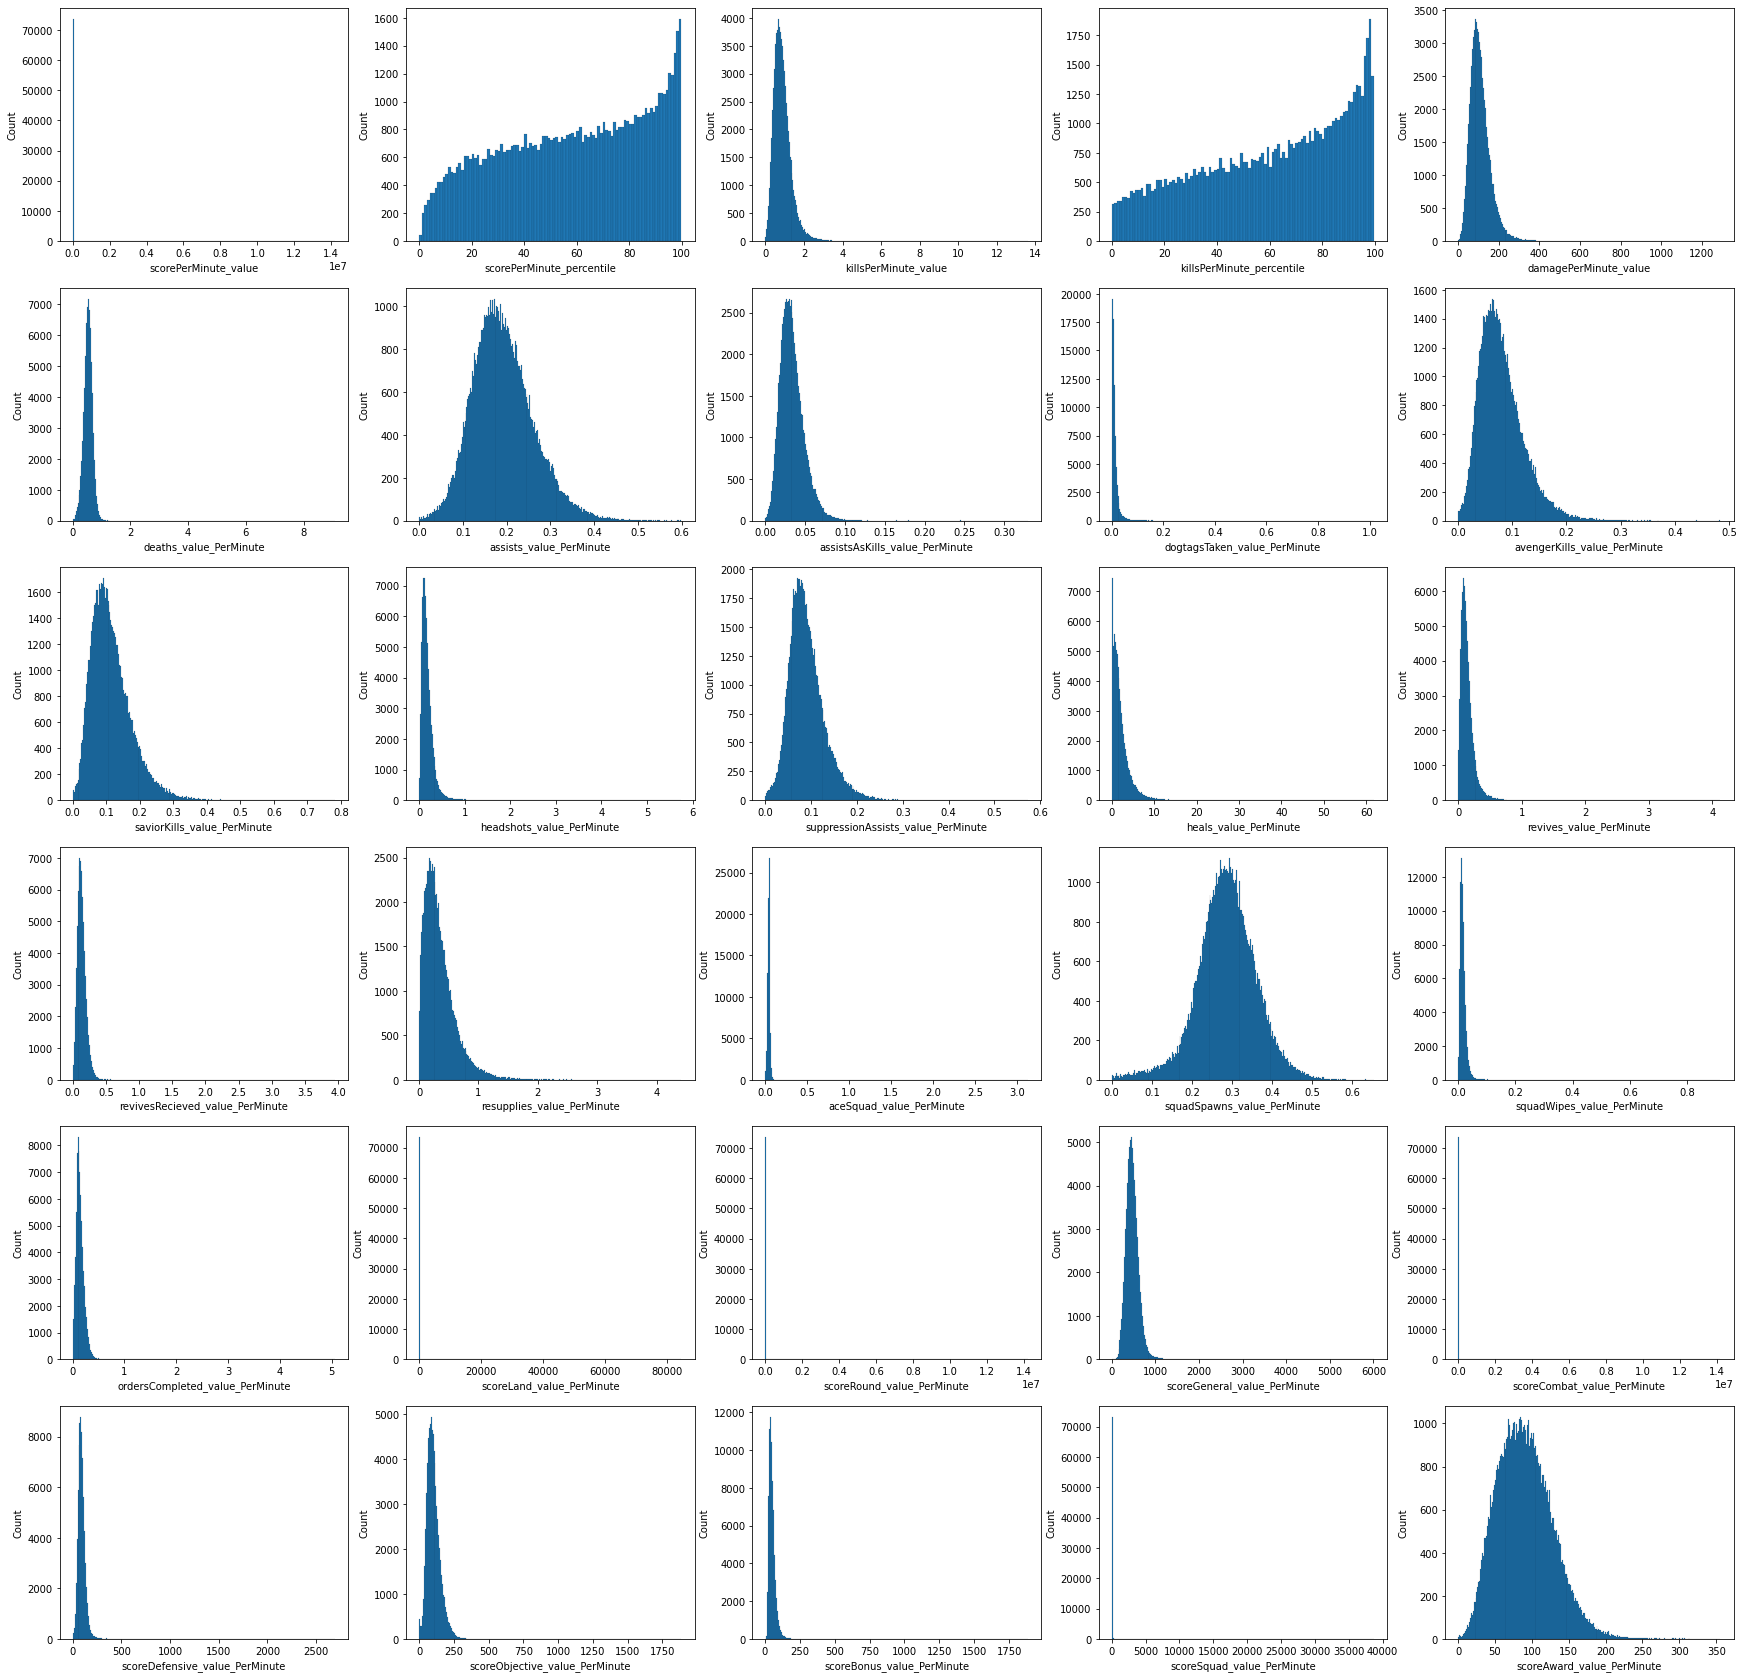

In [16]:
plot_features(general_features_per_minute, 6, 5, 30, 30, alternate_num_bins=0)

48it [00:20,  2.35it/s]


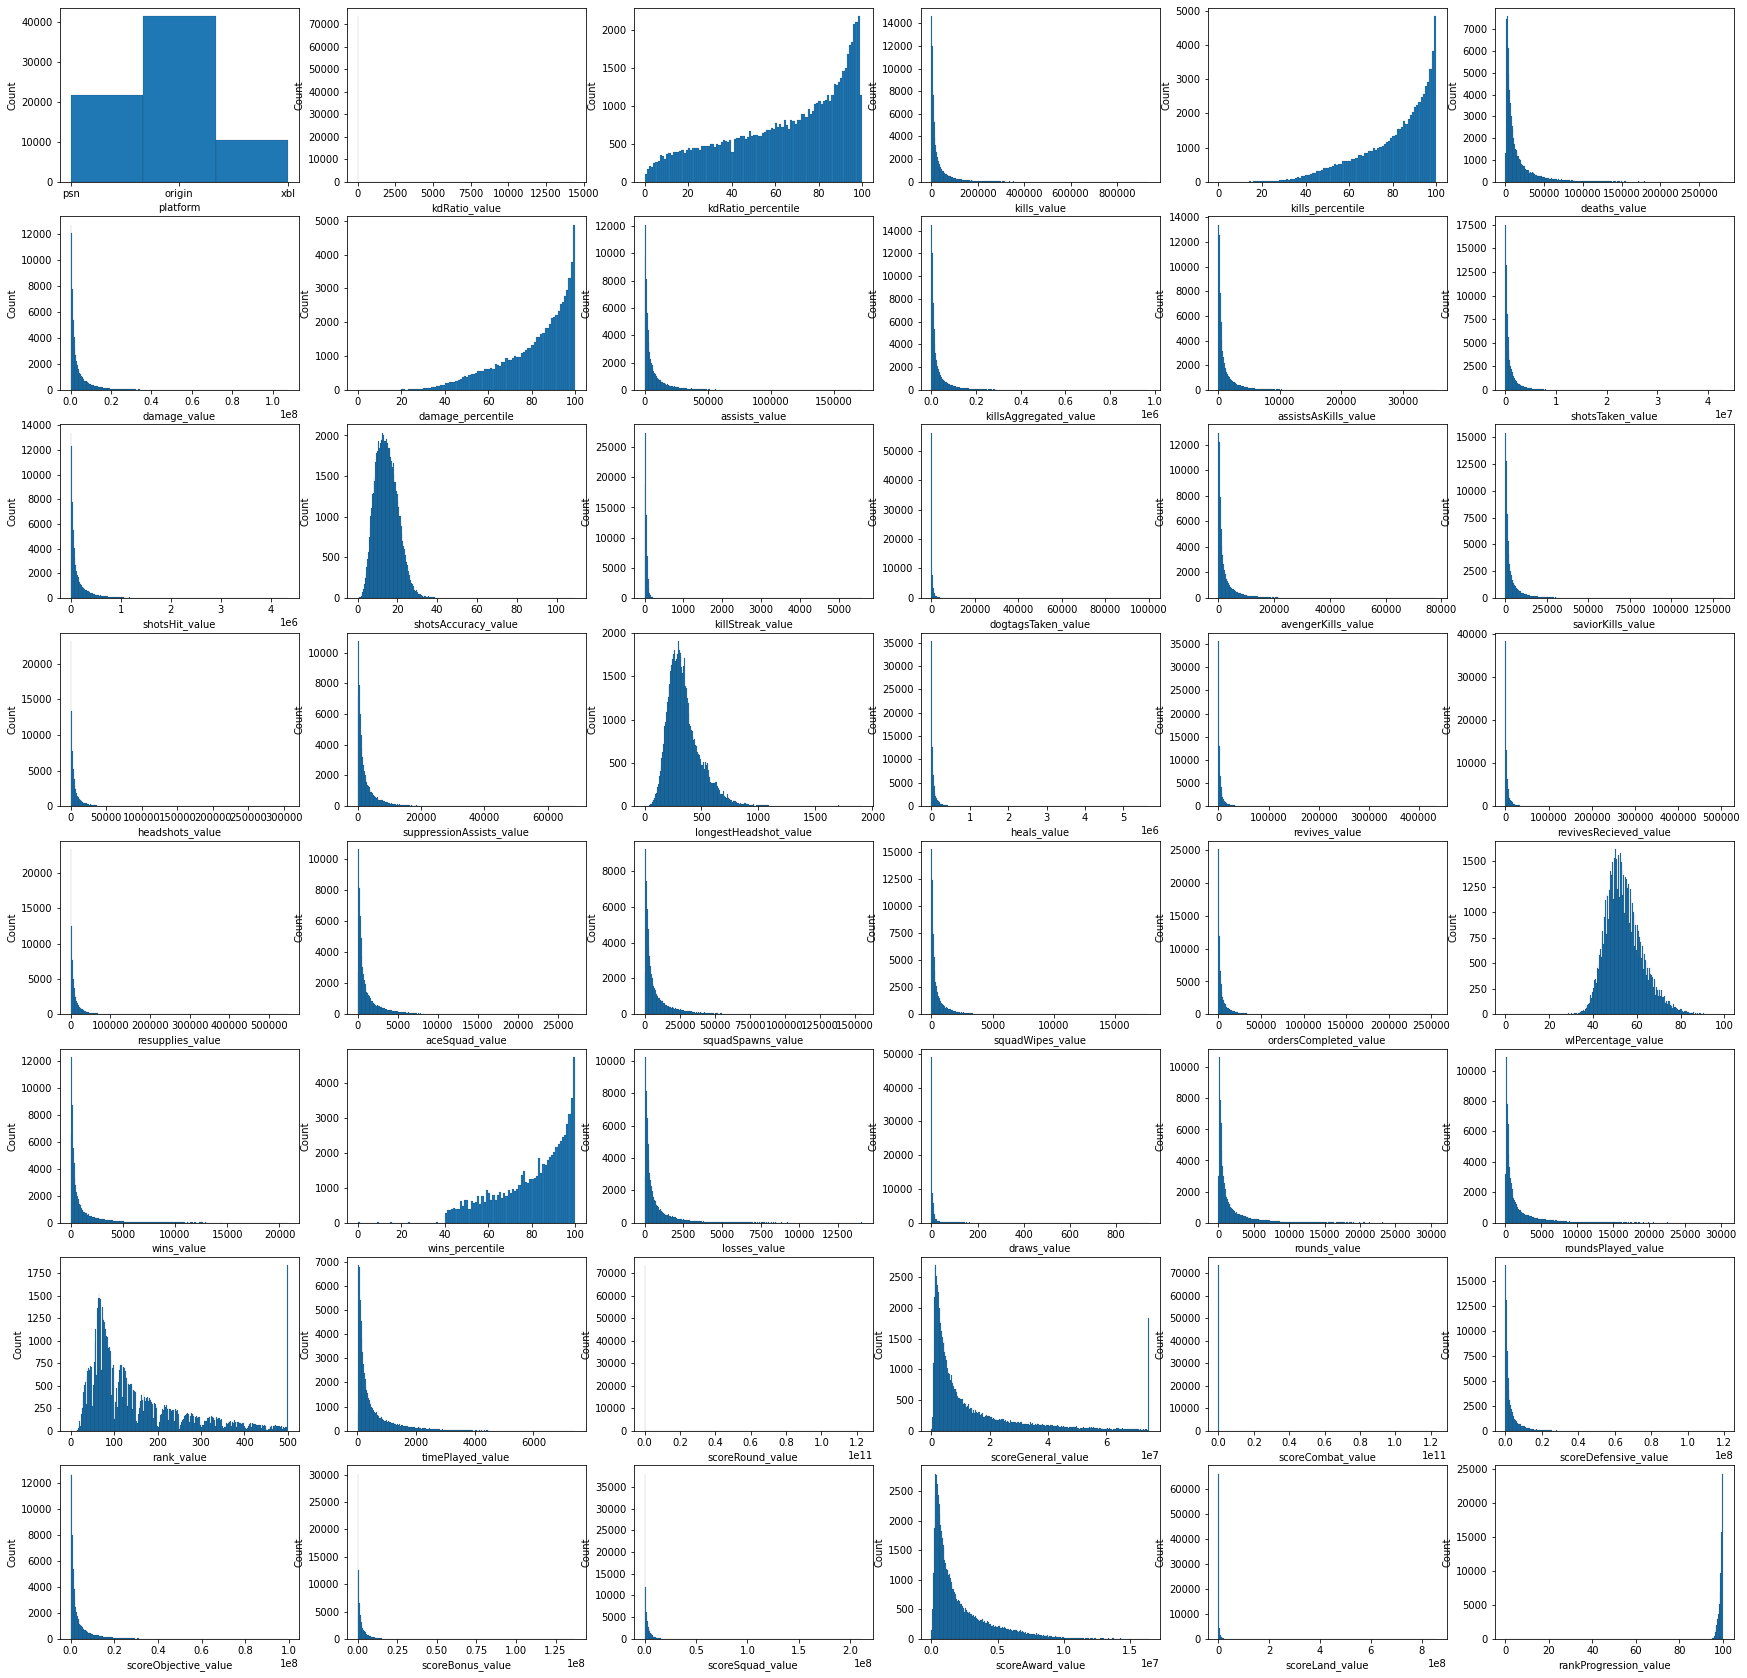

In [17]:
plot_features(general_feature_non_rate, 8, 6, 30, 30, alternate_num_bins=0)

## Medic Features
Note for the medic and all other classes, we have score features scaled by two different time features. Features named with the form like "Medic_scorePerMinute_value" is the score for the medic scaled by time spent playing the class. Features named with the form "scoreMedic_value_PerMinute" are scaled by total time spent playing the game.

15it [00:07,  1.89it/s]


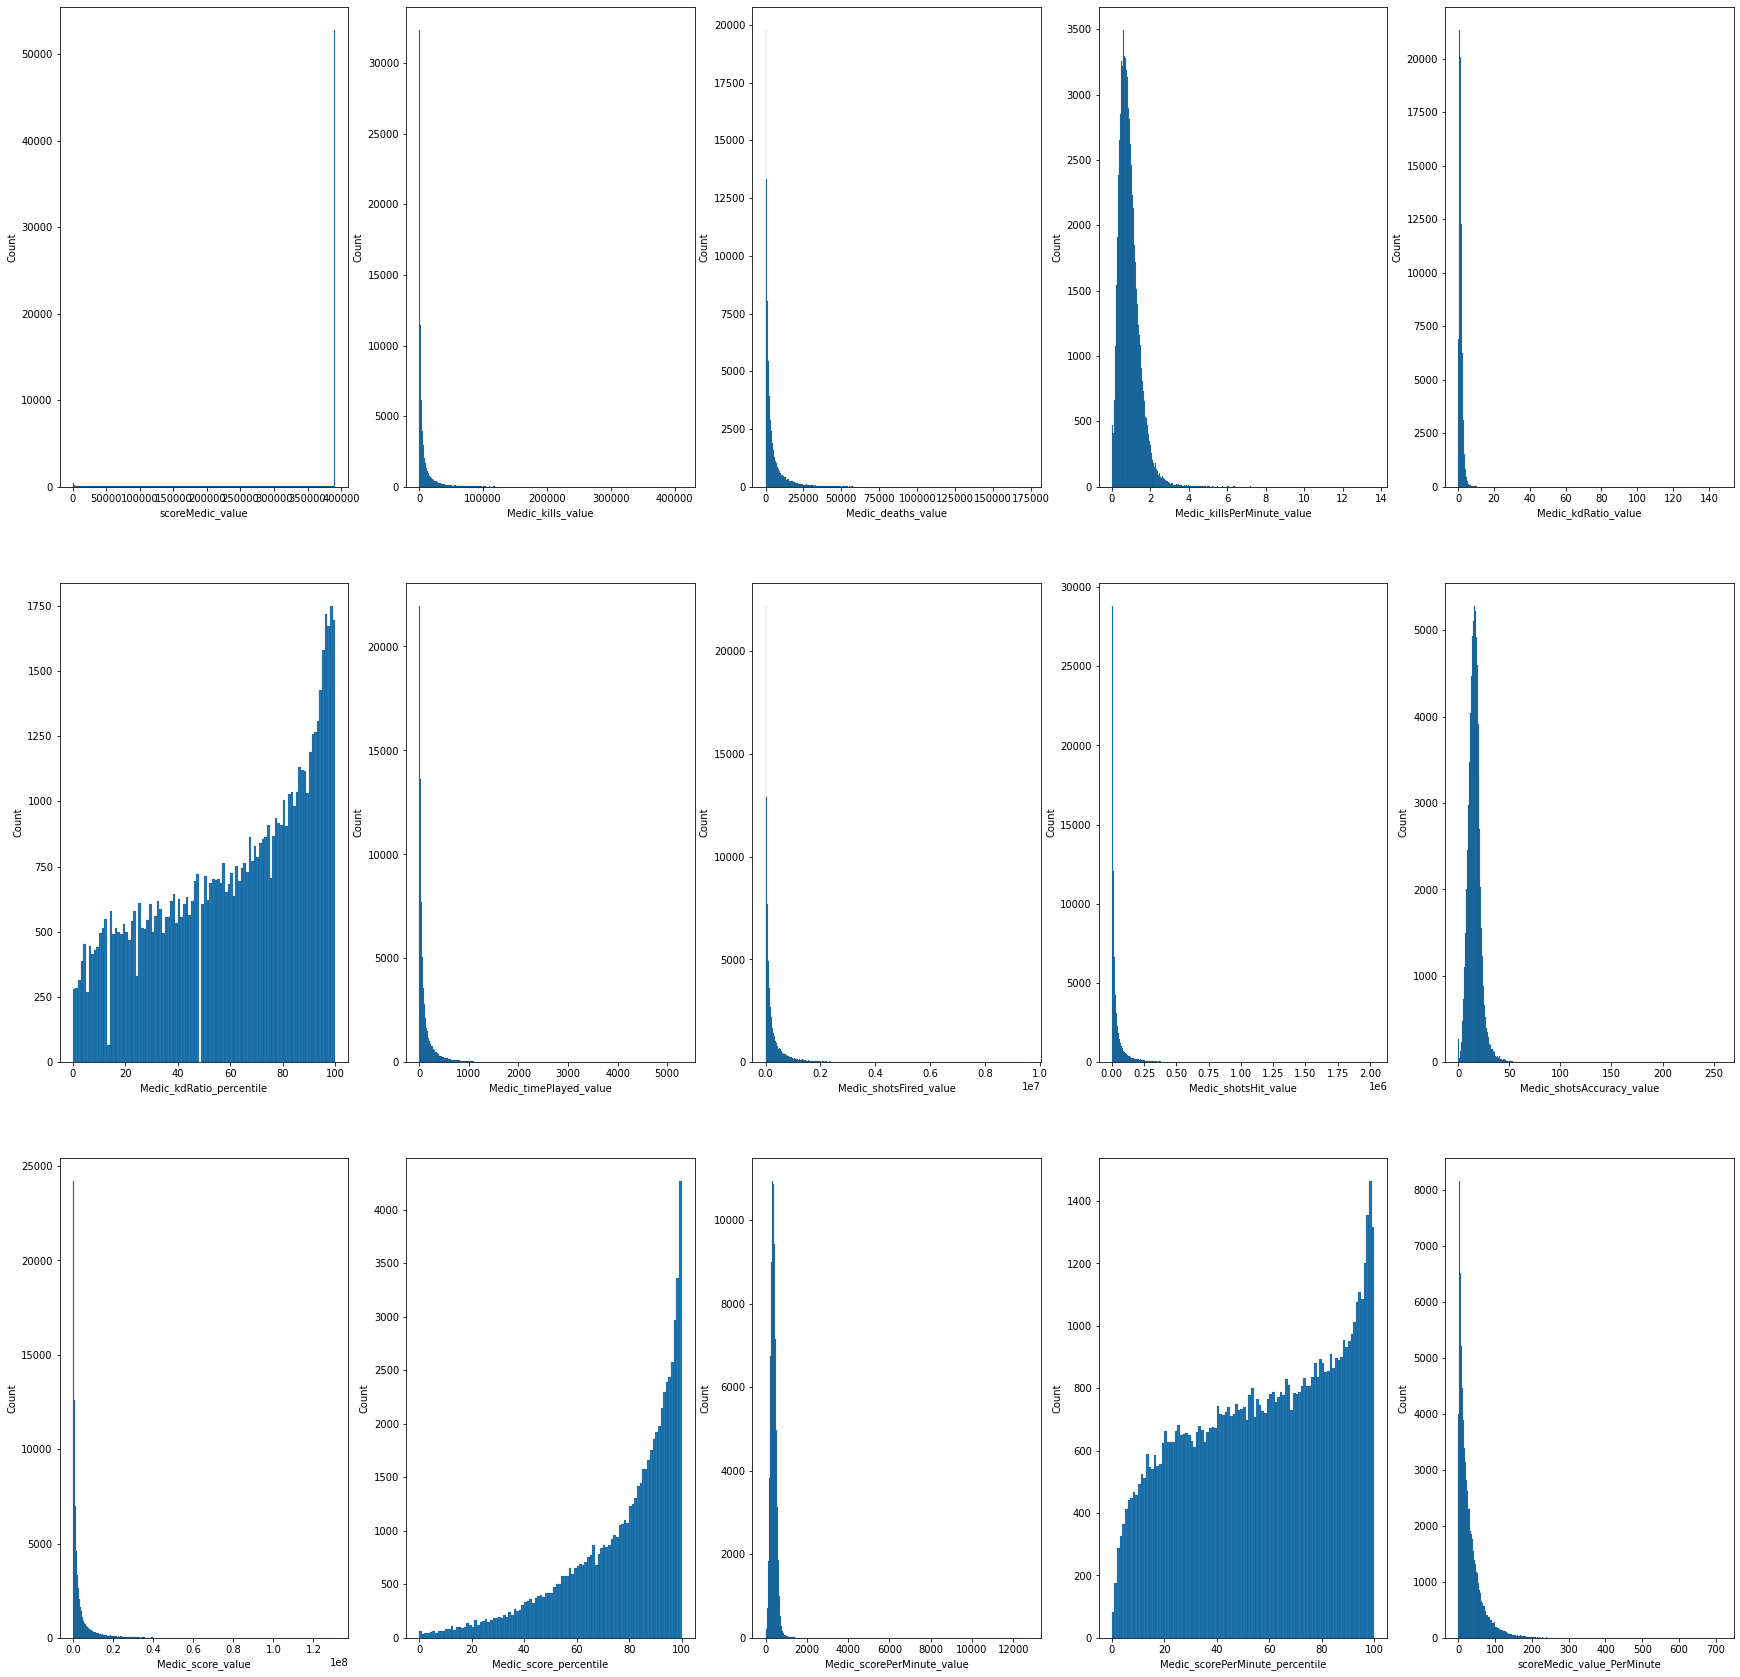

In [18]:
plot_features(medic_features, 3, 5, 30, 30, alternate_num_bins=0)

## Assault Features

In [19]:
plot_features(assault_features, 3, 5, 30, 30, alternate_num_bins=0)

15it [00:07,  2.08it/s]


## Support Features

15it [00:04,  3.16it/s]


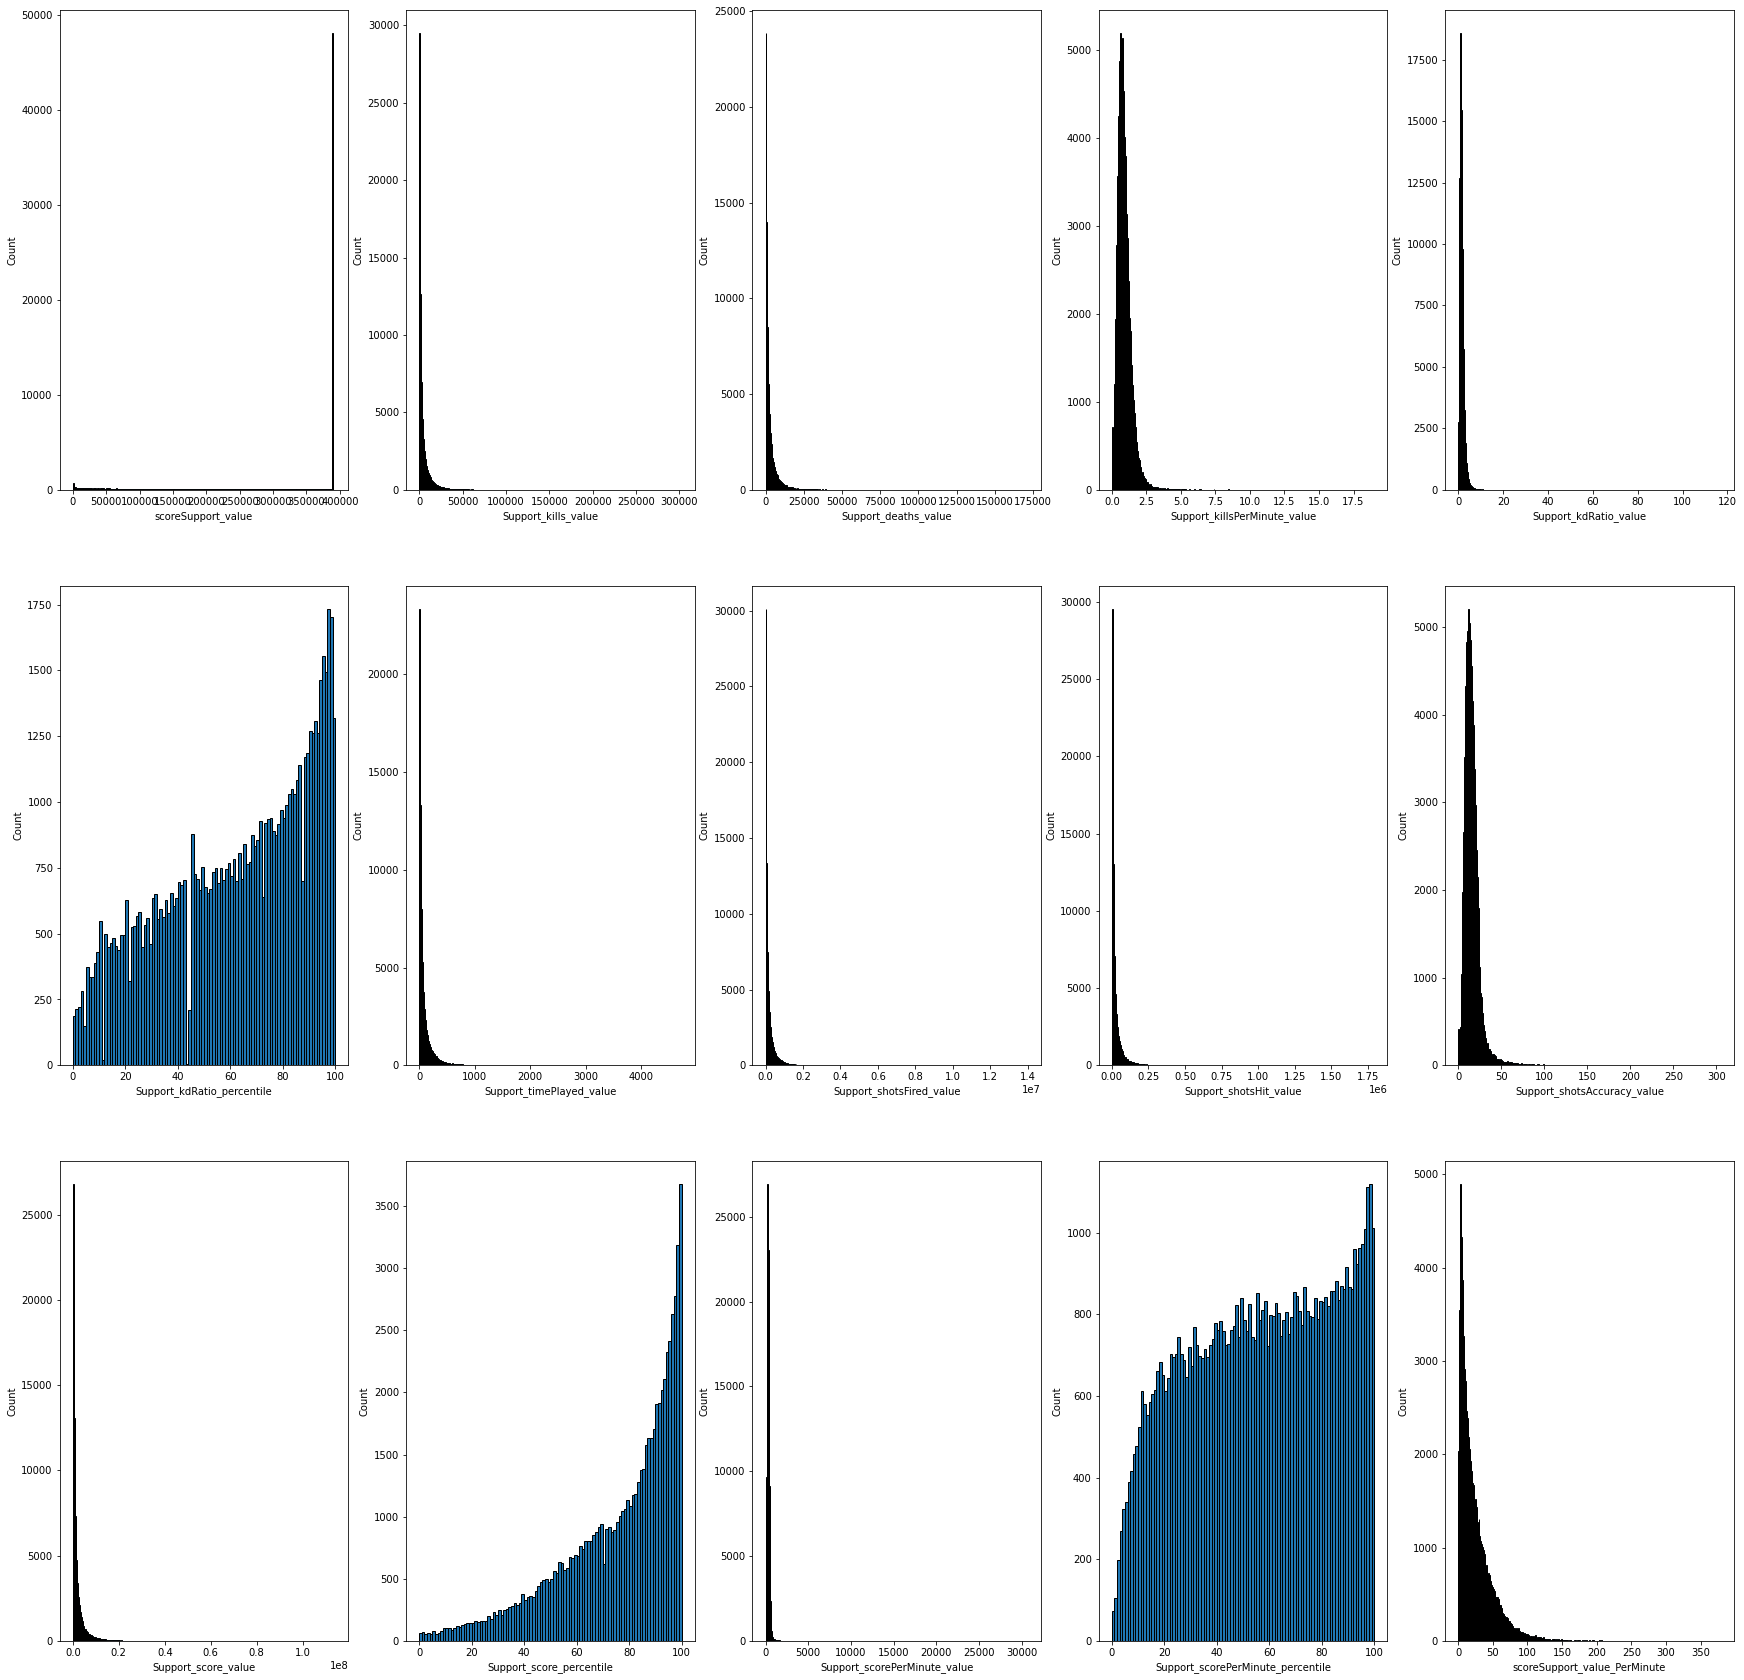

In [ ]:
plot_features(support_features, 3, 5, 30, 30, alternate_num_bins=0)

## Recon Features

15it [00:04,  3.39it/s]


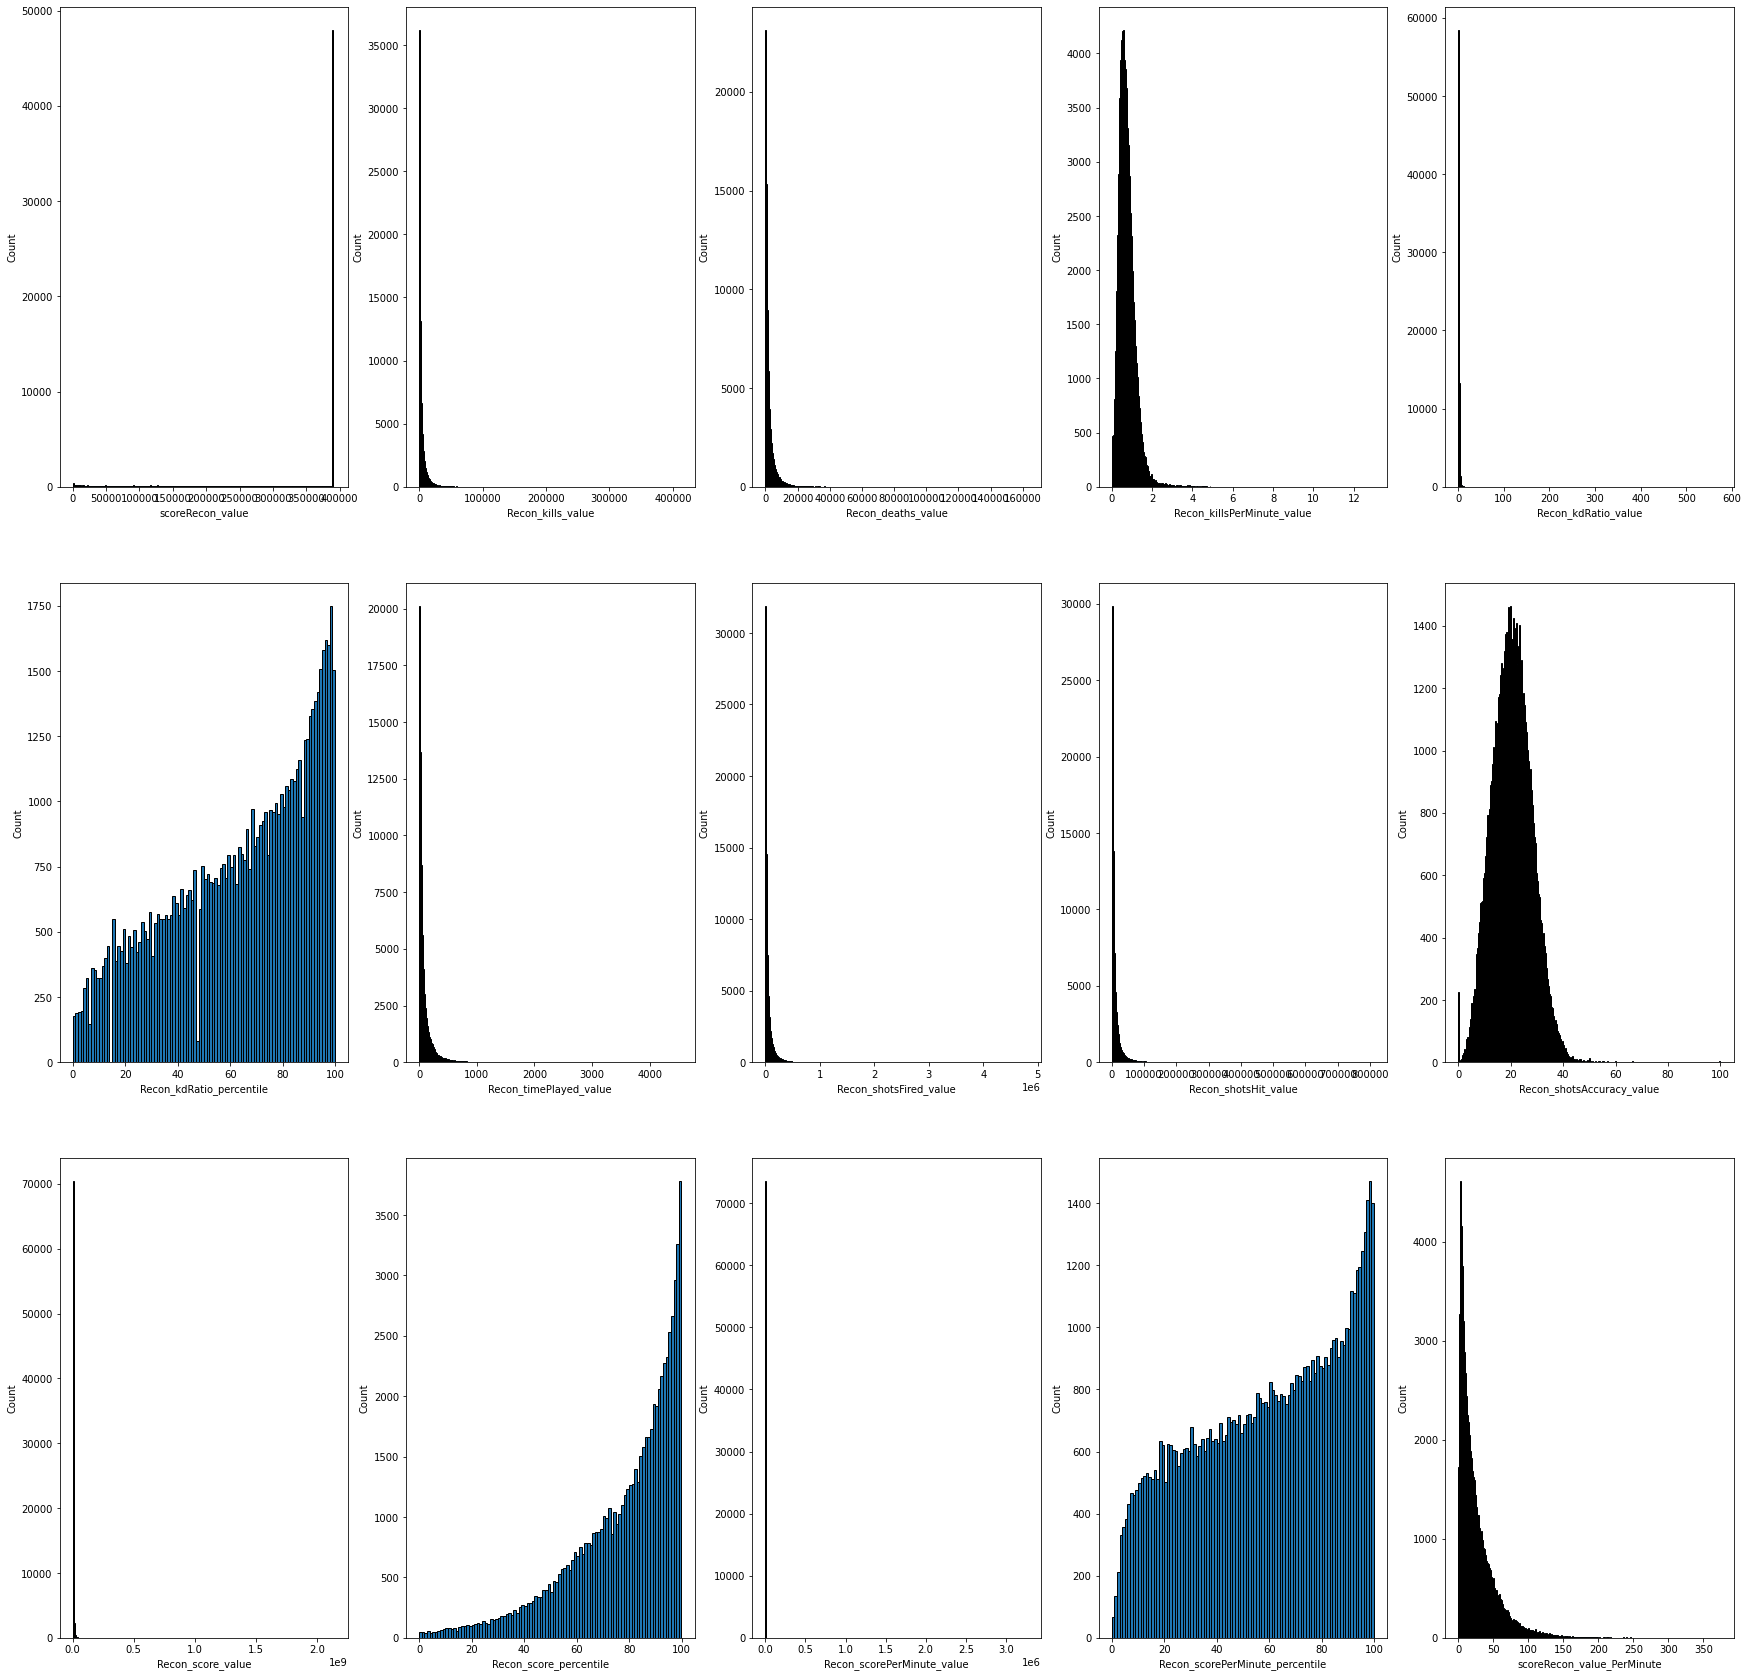

In [ ]:
plot_features(recon_features, 3, 5, 30, 30, alternate_num_bins=0)

## Ground Vehicle Features

11it [00:03,  3.58it/s]


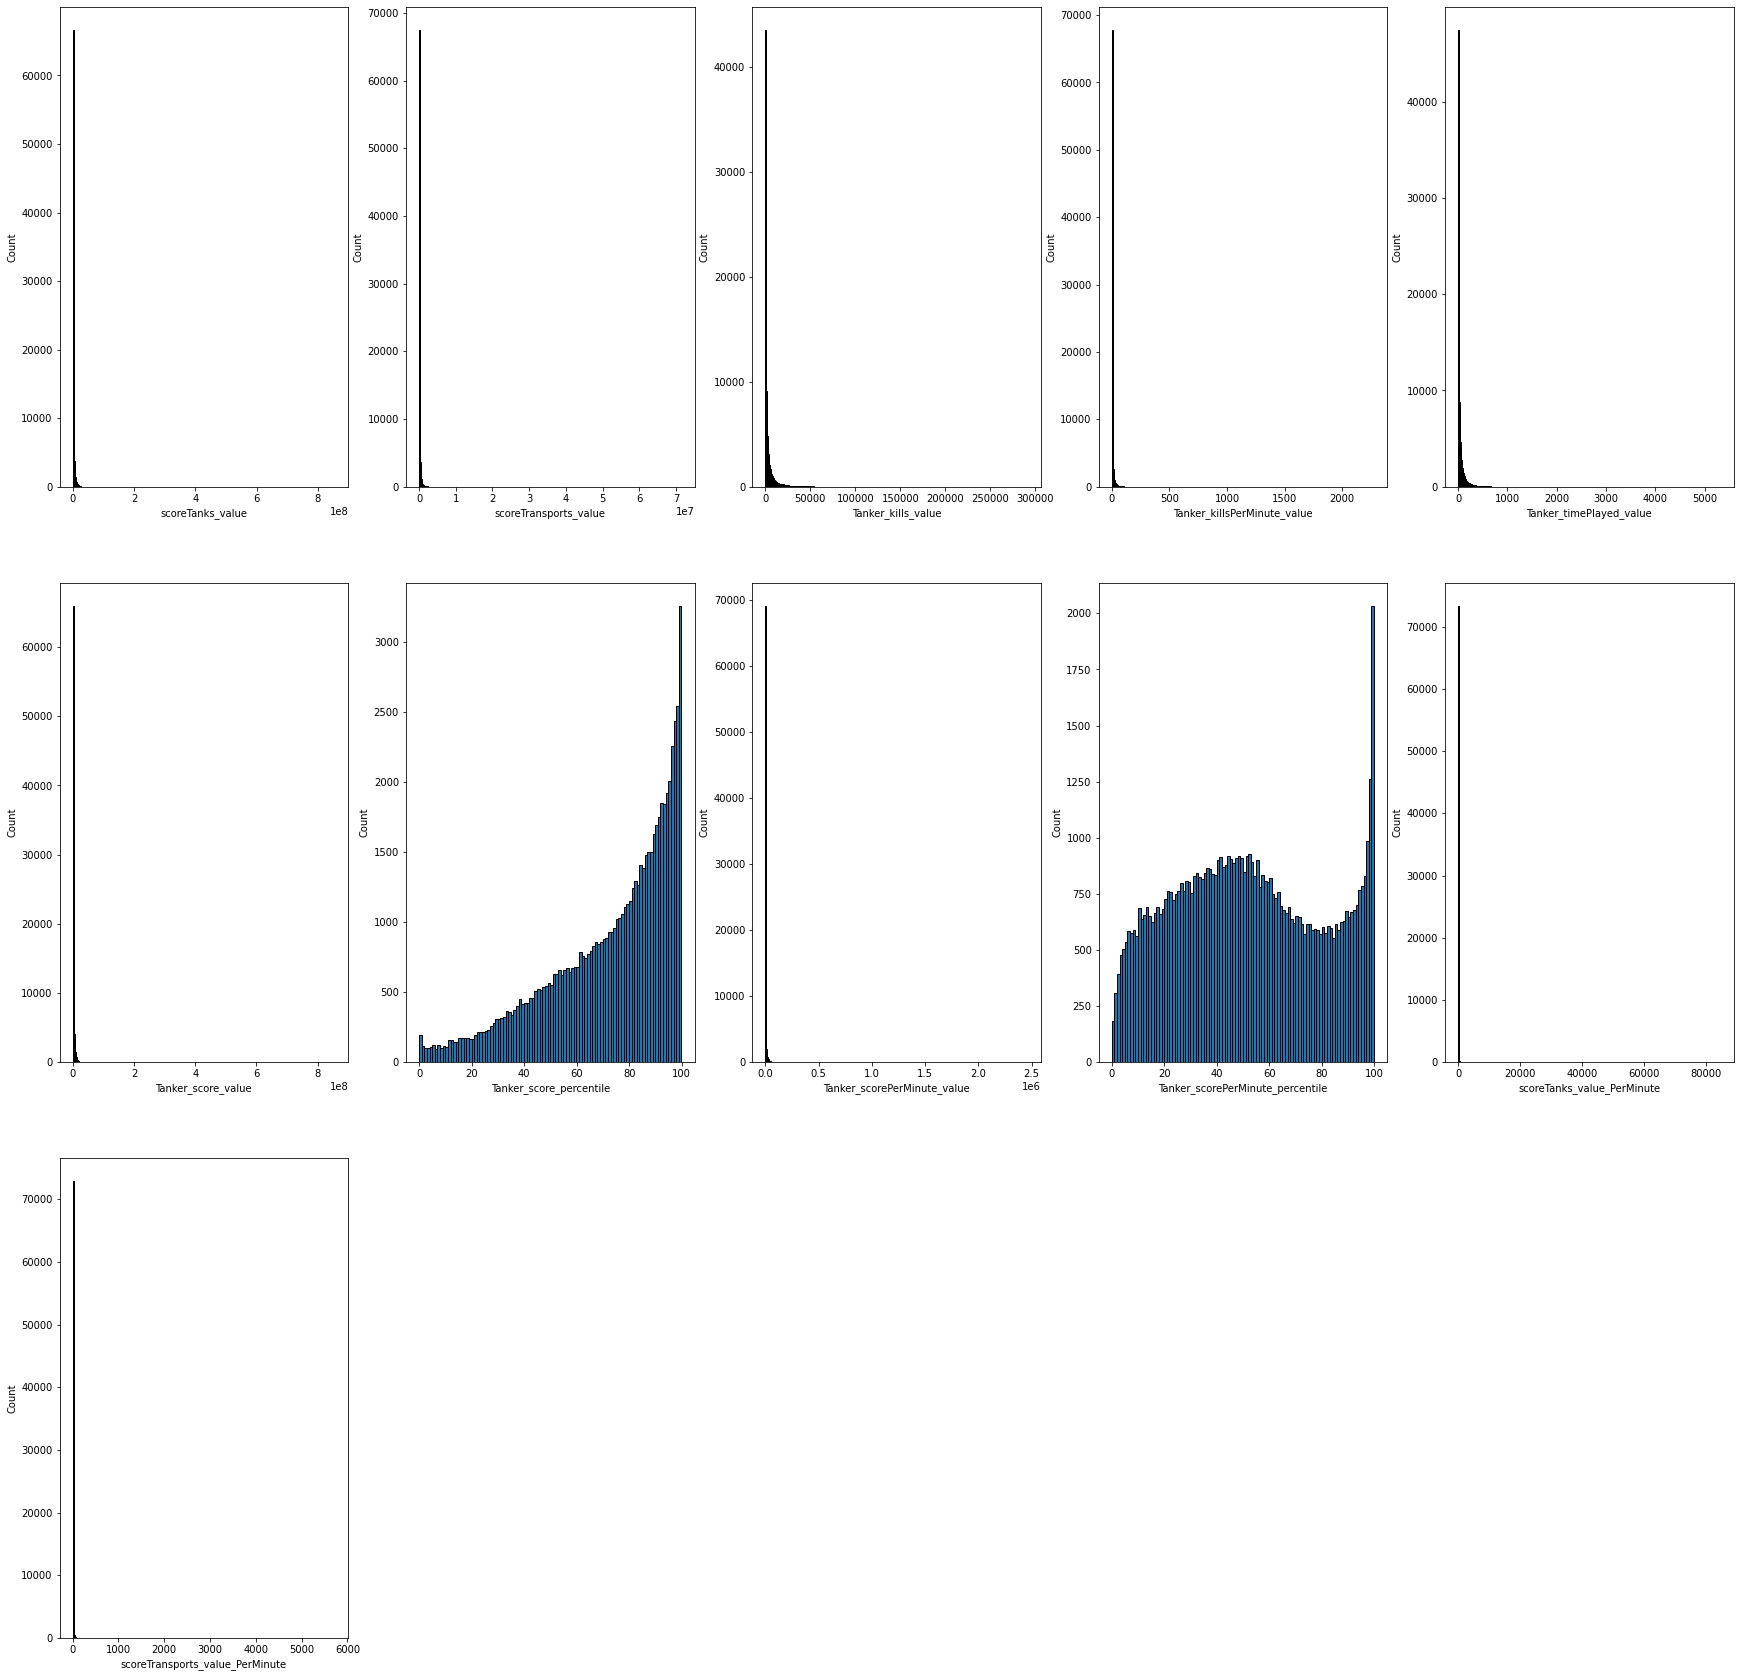

In [ ]:
plot_features(ground_vehicle_features, 3, 5, 30, 30, alternate_num_bins=0)

The scale of the distributions here suggest outliers in many of the ground vehicle features.

## Plane Features

11it [00:03,  3.31it/s]


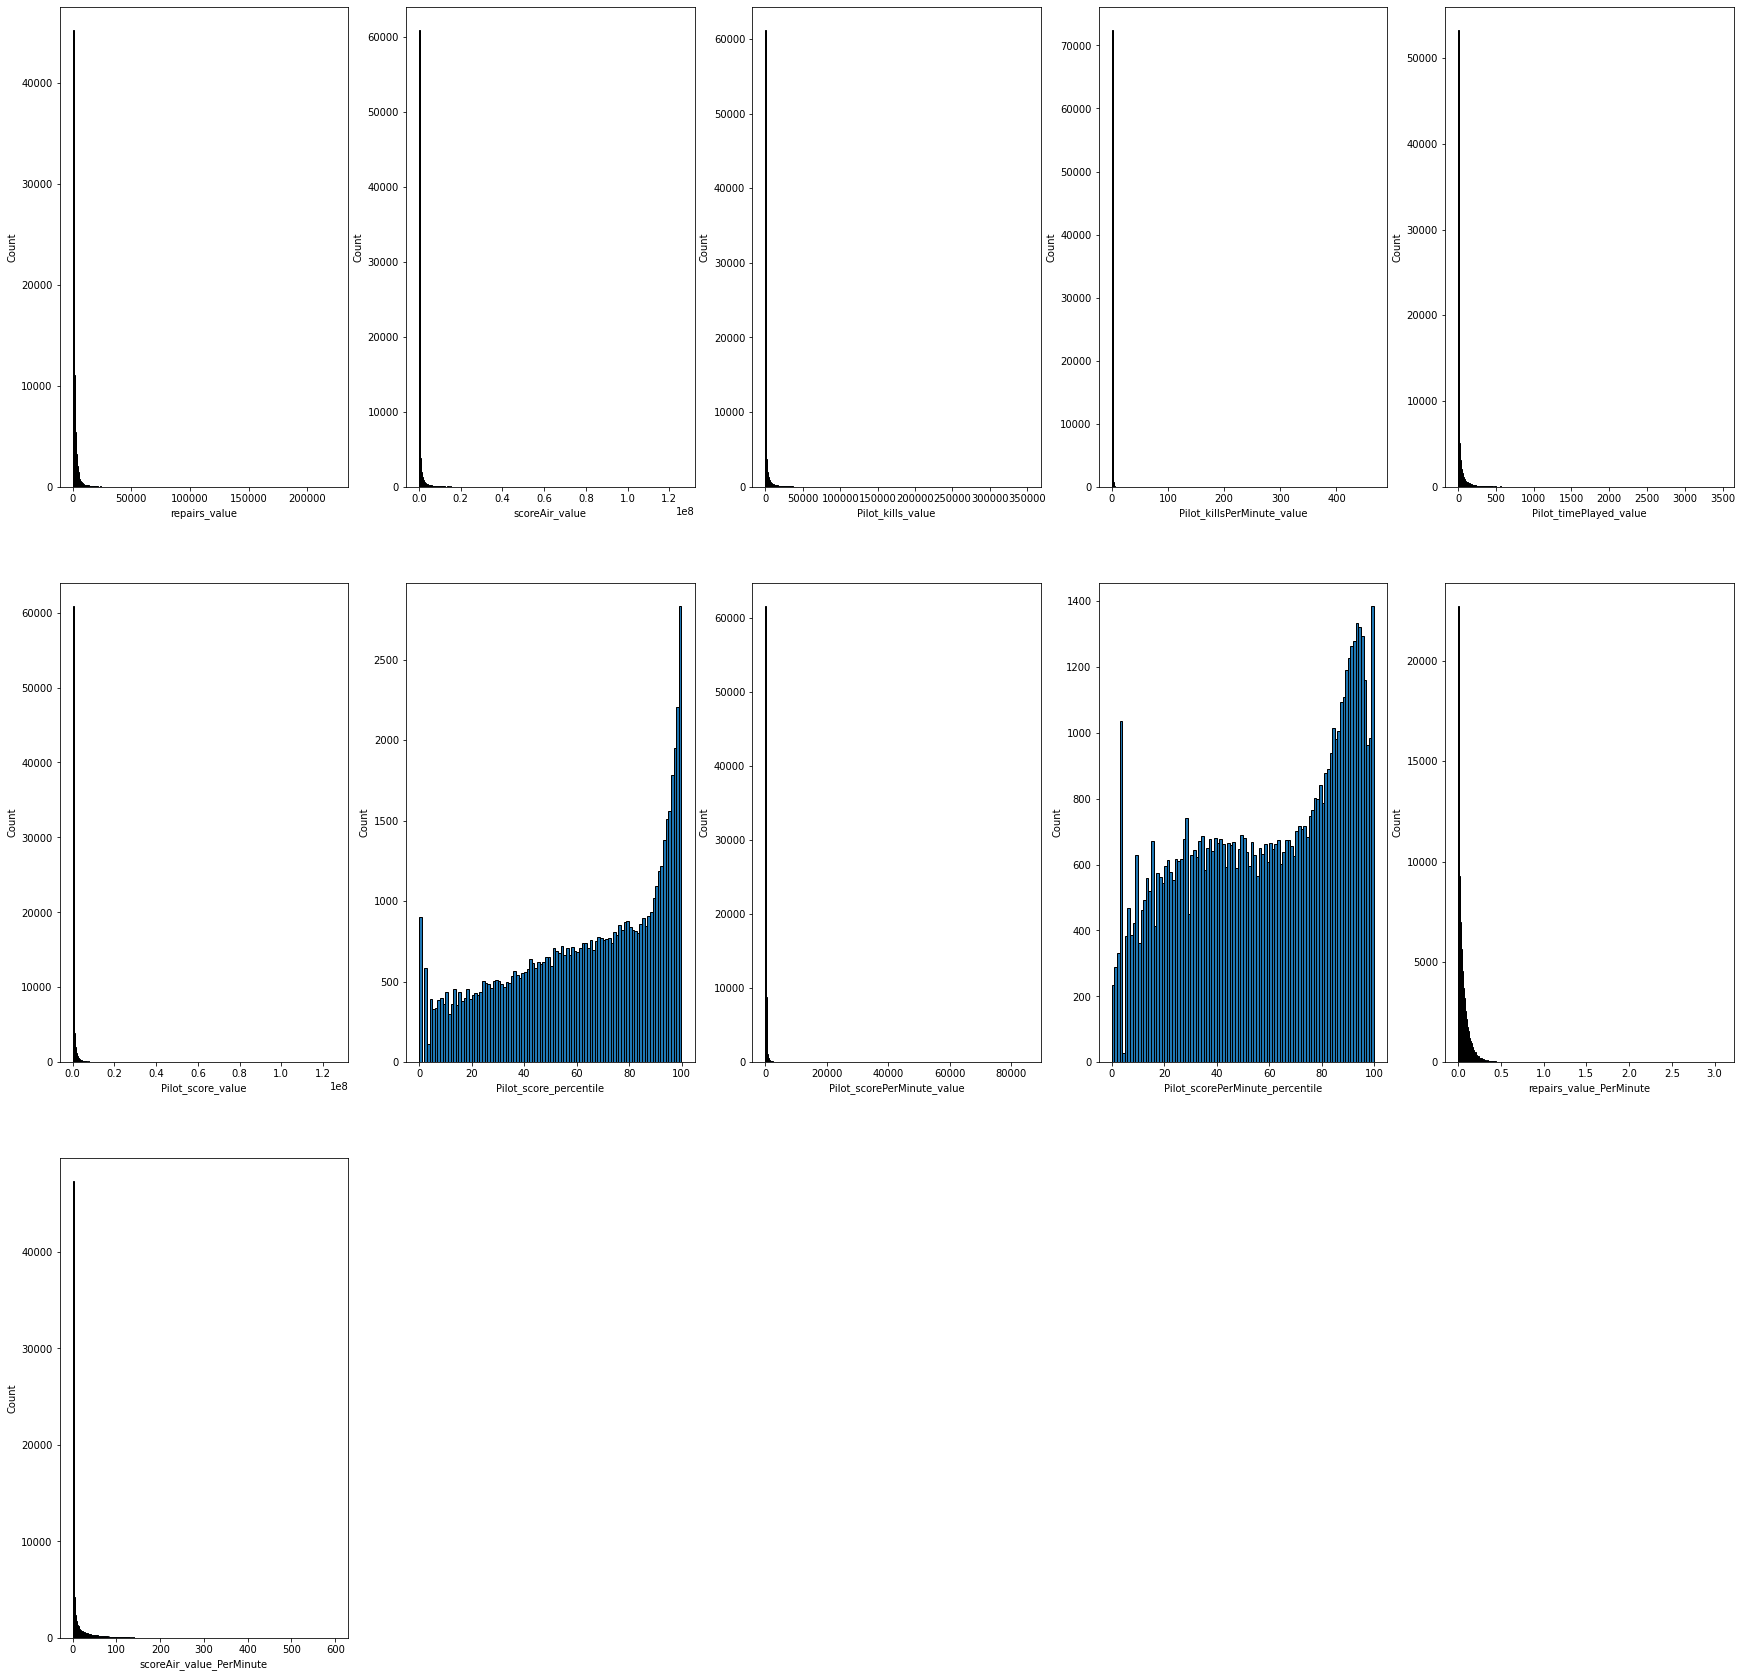

In [ ]:
plot_features(plane_features, 3, 5, 30, 30, alternate_num_bins=0)

## Correlations

In [ ]:
high_corr = 0.5
corr_features = []
corr = df[df.columns[1:]].corr() # select only numerical features

# select only features with correlations above threshold
for feature in corr.columns: # numerical columns only
    feat_max_corr = corr[corr[feature] < 1][feature].max() # Ignore correlations of one, since all correlations on the diagonal are 1
    feat_min_corr = corr[corr[feature] < 1][feature].min()
    if np.abs(feat_min_corr) > high_corr or feat_max_corr > high_corr:
        corr_features.append(feature)

print('The following portion of features have substantial (positive or negative) correlation with other features:', len(corr_features)/len(corr.columns))
large_corr = corr[corr_features].loc[corr_features]

The following portion of features have substantial (positive or negative) correlation with other features: 0.9245283018867925


We can immediately determine from the above that almost all of the features are fairly strongly correlated with at least one other feature. This is not particularly surprising. We have, for example, certain metrics that are tracked as totals as well as per minute values, which we would expect to be correlated. We also have features that are sums of other features, for example, we track overall score but also score gained defensively. Further, given knowledge of the game, we can expect certain scores to correlate with others. We would expect, for example, score per minute to correlate with kill death ratio, as getting more kills and dying less is an effective way to score more points per minute.

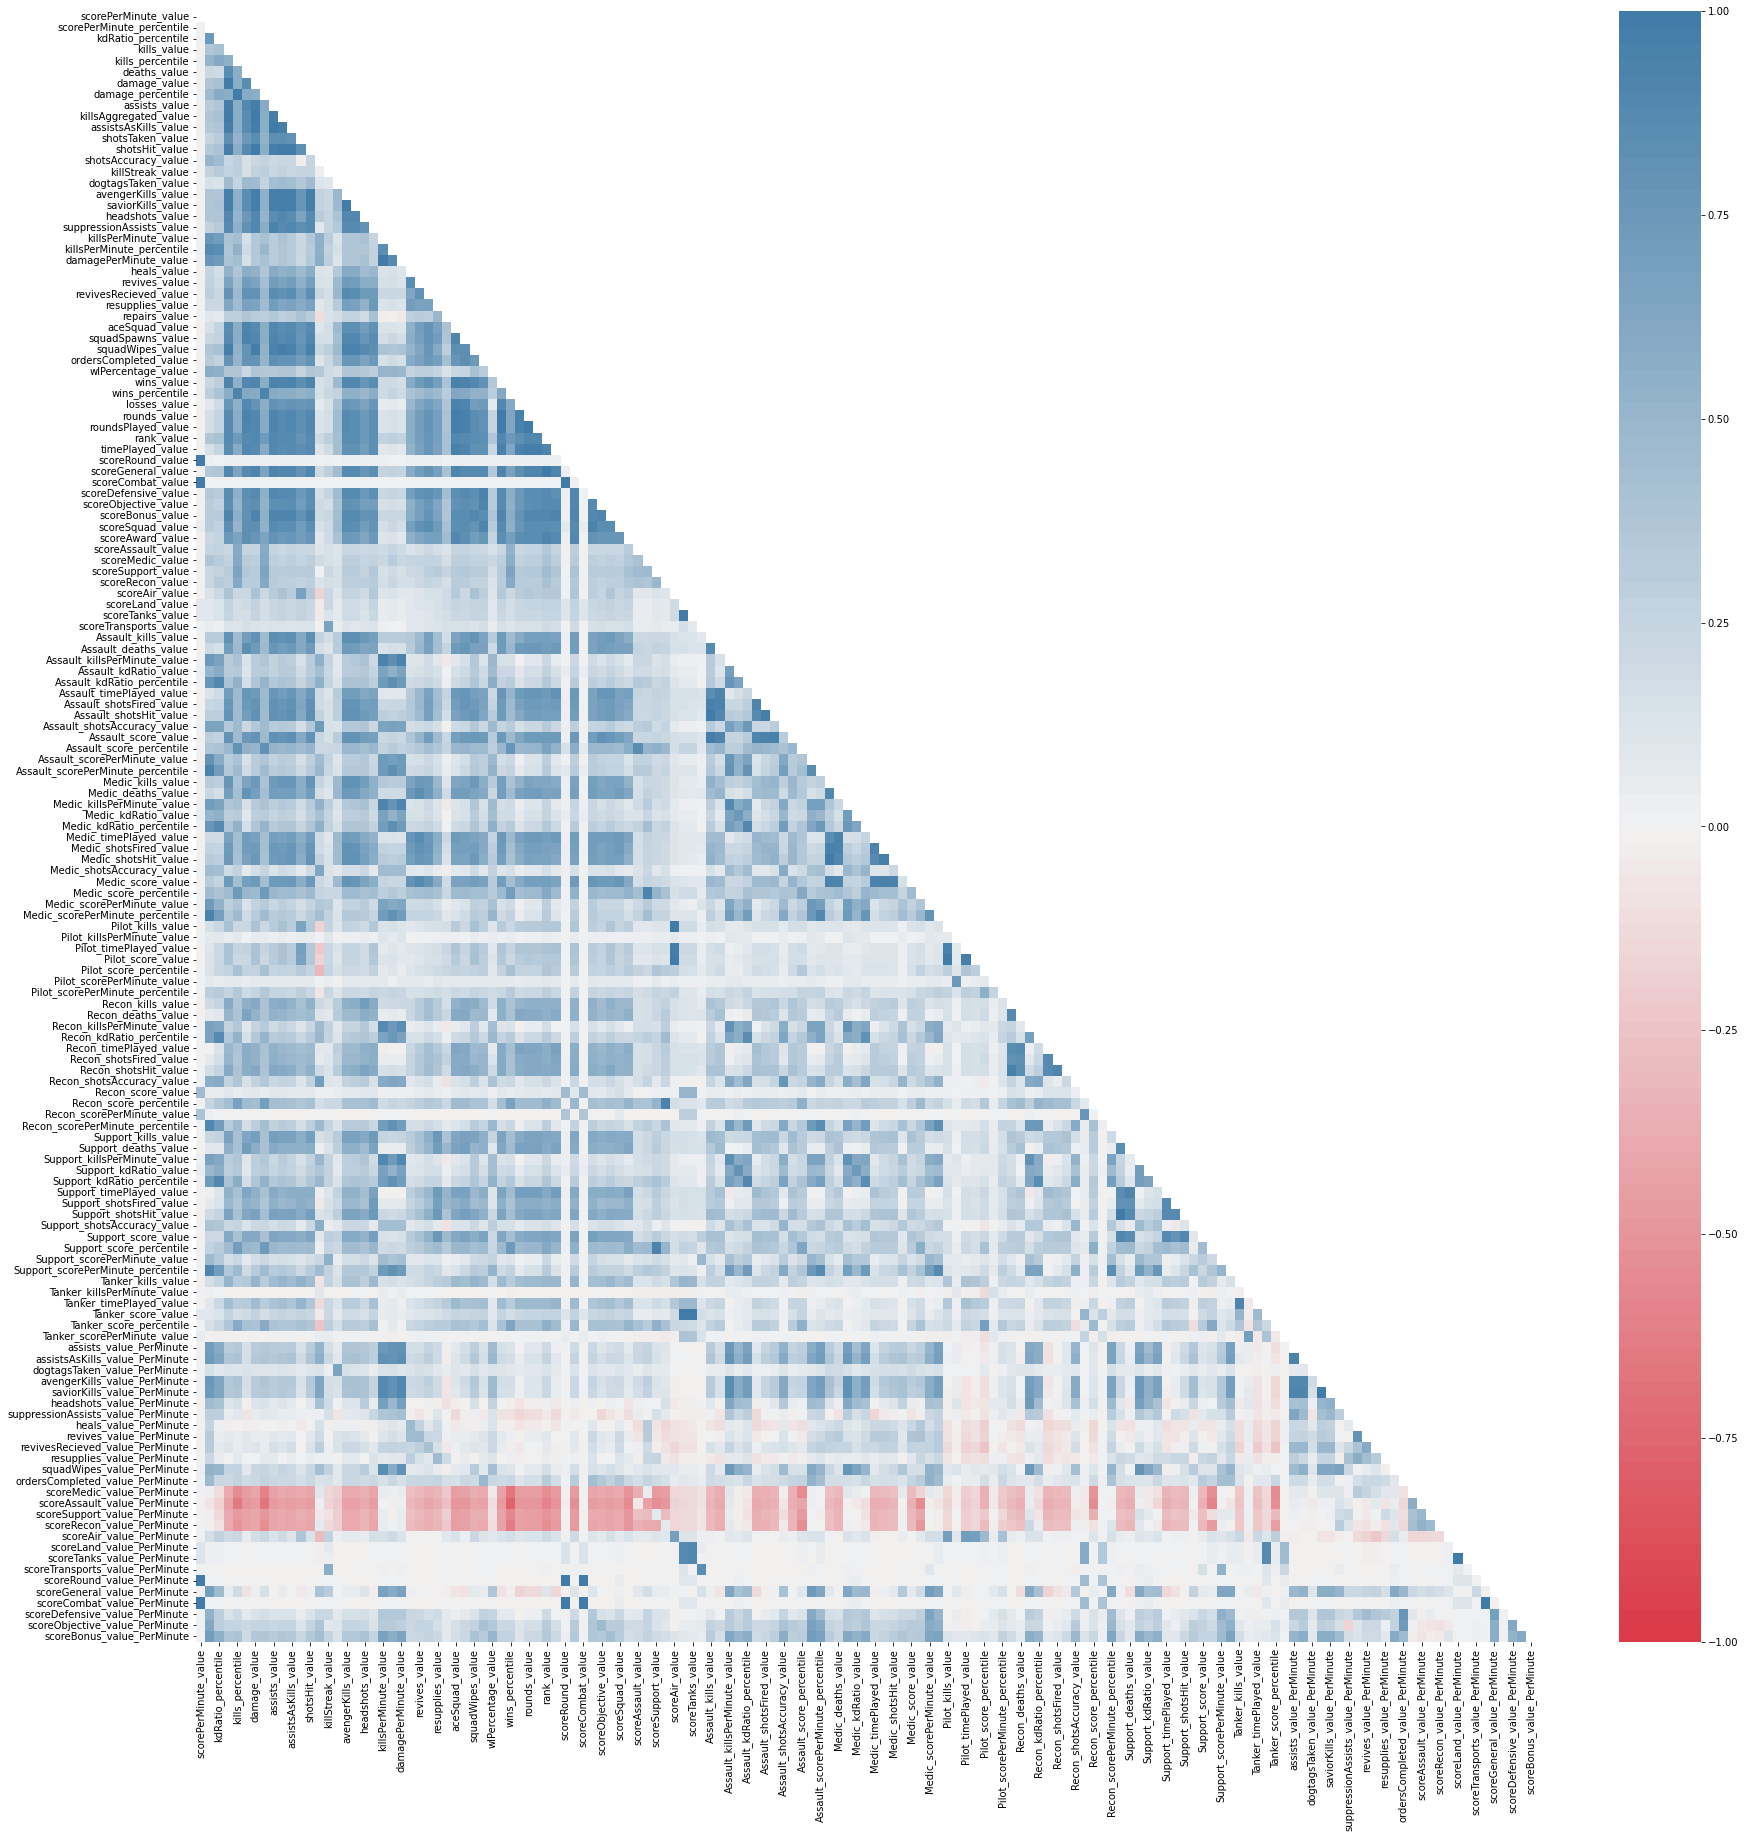

In [ ]:
# Plotting correlations
mask = np.triu(large_corr)
cmap = sns.diverging_palette(10, 240, n=100)
plt.figure(figsize=(30,30))
sns.heatmap(large_corr,vmin=-1, vmax=1, cmap=cmap, mask=mask)
plt.show()

While the plot has not been marked up with values for specific correlations for the sake of readability, the phenomena discussed in the cell above the plot can be observed from looking at the plot.

It would be good to focus in on some features. To determine how to do this, I sum the absolute value of the correlation coeficients for each feature and subtract one (to account for the correlation between the feature and itself). I divide the sum by total number of features, for readability. I then sort the features by the value of that sum.

In [ ]:
corr_sum = np.sum(np.abs(corr), axis=1) - 1
corr_sum = corr_sum.sort_values(ascending=False) / len(corr.columns)
print('Features with the highest mean of absolute value of correlation coefficients')
corr_sum.head(20)

Features with the highest mean of absolute value of correlation coefficients


damage_value                0.429905
rank_value                  0.429699
killsAggregated_value       0.428993
kills_value                 0.428759
shotsHit_value              0.425183
assists_value               0.425163
scoreGeneral_value          0.424226
avengerKills_value          0.422419
assistsAsKills_value        0.422245
saviorKills_value           0.422086
squadWipes_value            0.417955
scoreDefensive_value        0.407301
scoreBonus_value            0.406221
wins_value                  0.401061
suppressionAssists_value    0.392073
squadSpawns_value           0.391983
headshots_value             0.389978
rounds_value                0.389953
scoreSquad_value            0.389754
roundsPlayed_value          0.389713
dtype: float64

In [ ]:
print('Features with the smallest mean of absolute value of correlation coefficients')
corr_sum.tail(20)

Features with the smallest mean of absolute value of correlation coefficients


scoreTransports_value              0.084457
repairs_value_PerMinute            0.083794
Recon_kdRatio_value                0.083741
dogtagsTaken_value_PerMinute       0.081204
scoreRound_value                   0.057125
Pilot_scorePerMinute_value         0.054789
scoreLand_value_PerMinute          0.049900
scoreSquad_value_PerMinute         0.048961
aceSquad_value_PerMinute           0.048364
scoreTanks_value_PerMinute         0.048209
scoreCombat_value                  0.047720
Pilot_killsPerMinute_value         0.044241
scorePerMinute_value               0.042069
scoreRound_value_PerMinute         0.042069
scoreCombat_value_PerMinute        0.041962
Tanker_scorePerMinute_value        0.039750
Recon_scorePerMinute_value         0.037283
Tanker_killsPerMinute_value        0.028651
scoreTransports_value_PerMinute    0.028097
kdRatio_value                      0.014576
dtype: float64

We can also plot a distribution of these sums.

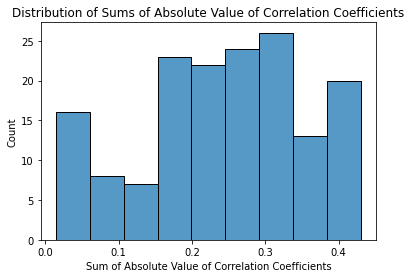

In [ ]:
sns.histplot(corr_sum)
plt.xlabel('Sum of Absolute Value of Correlation Coefficients')
plt.ylabel('Count')
plt.title('Distribution of Sums of Absolute Value of Correlation Coefficients')
plt.show()

We can then plot heatmaps just looking at the ten figures with the largest and smallest average correlation respectively. First, the large average correlation features.

In [ ]:
small_corr_features = corr_sum.tail(20).index
large_corr_features = corr_sum.head(20).index

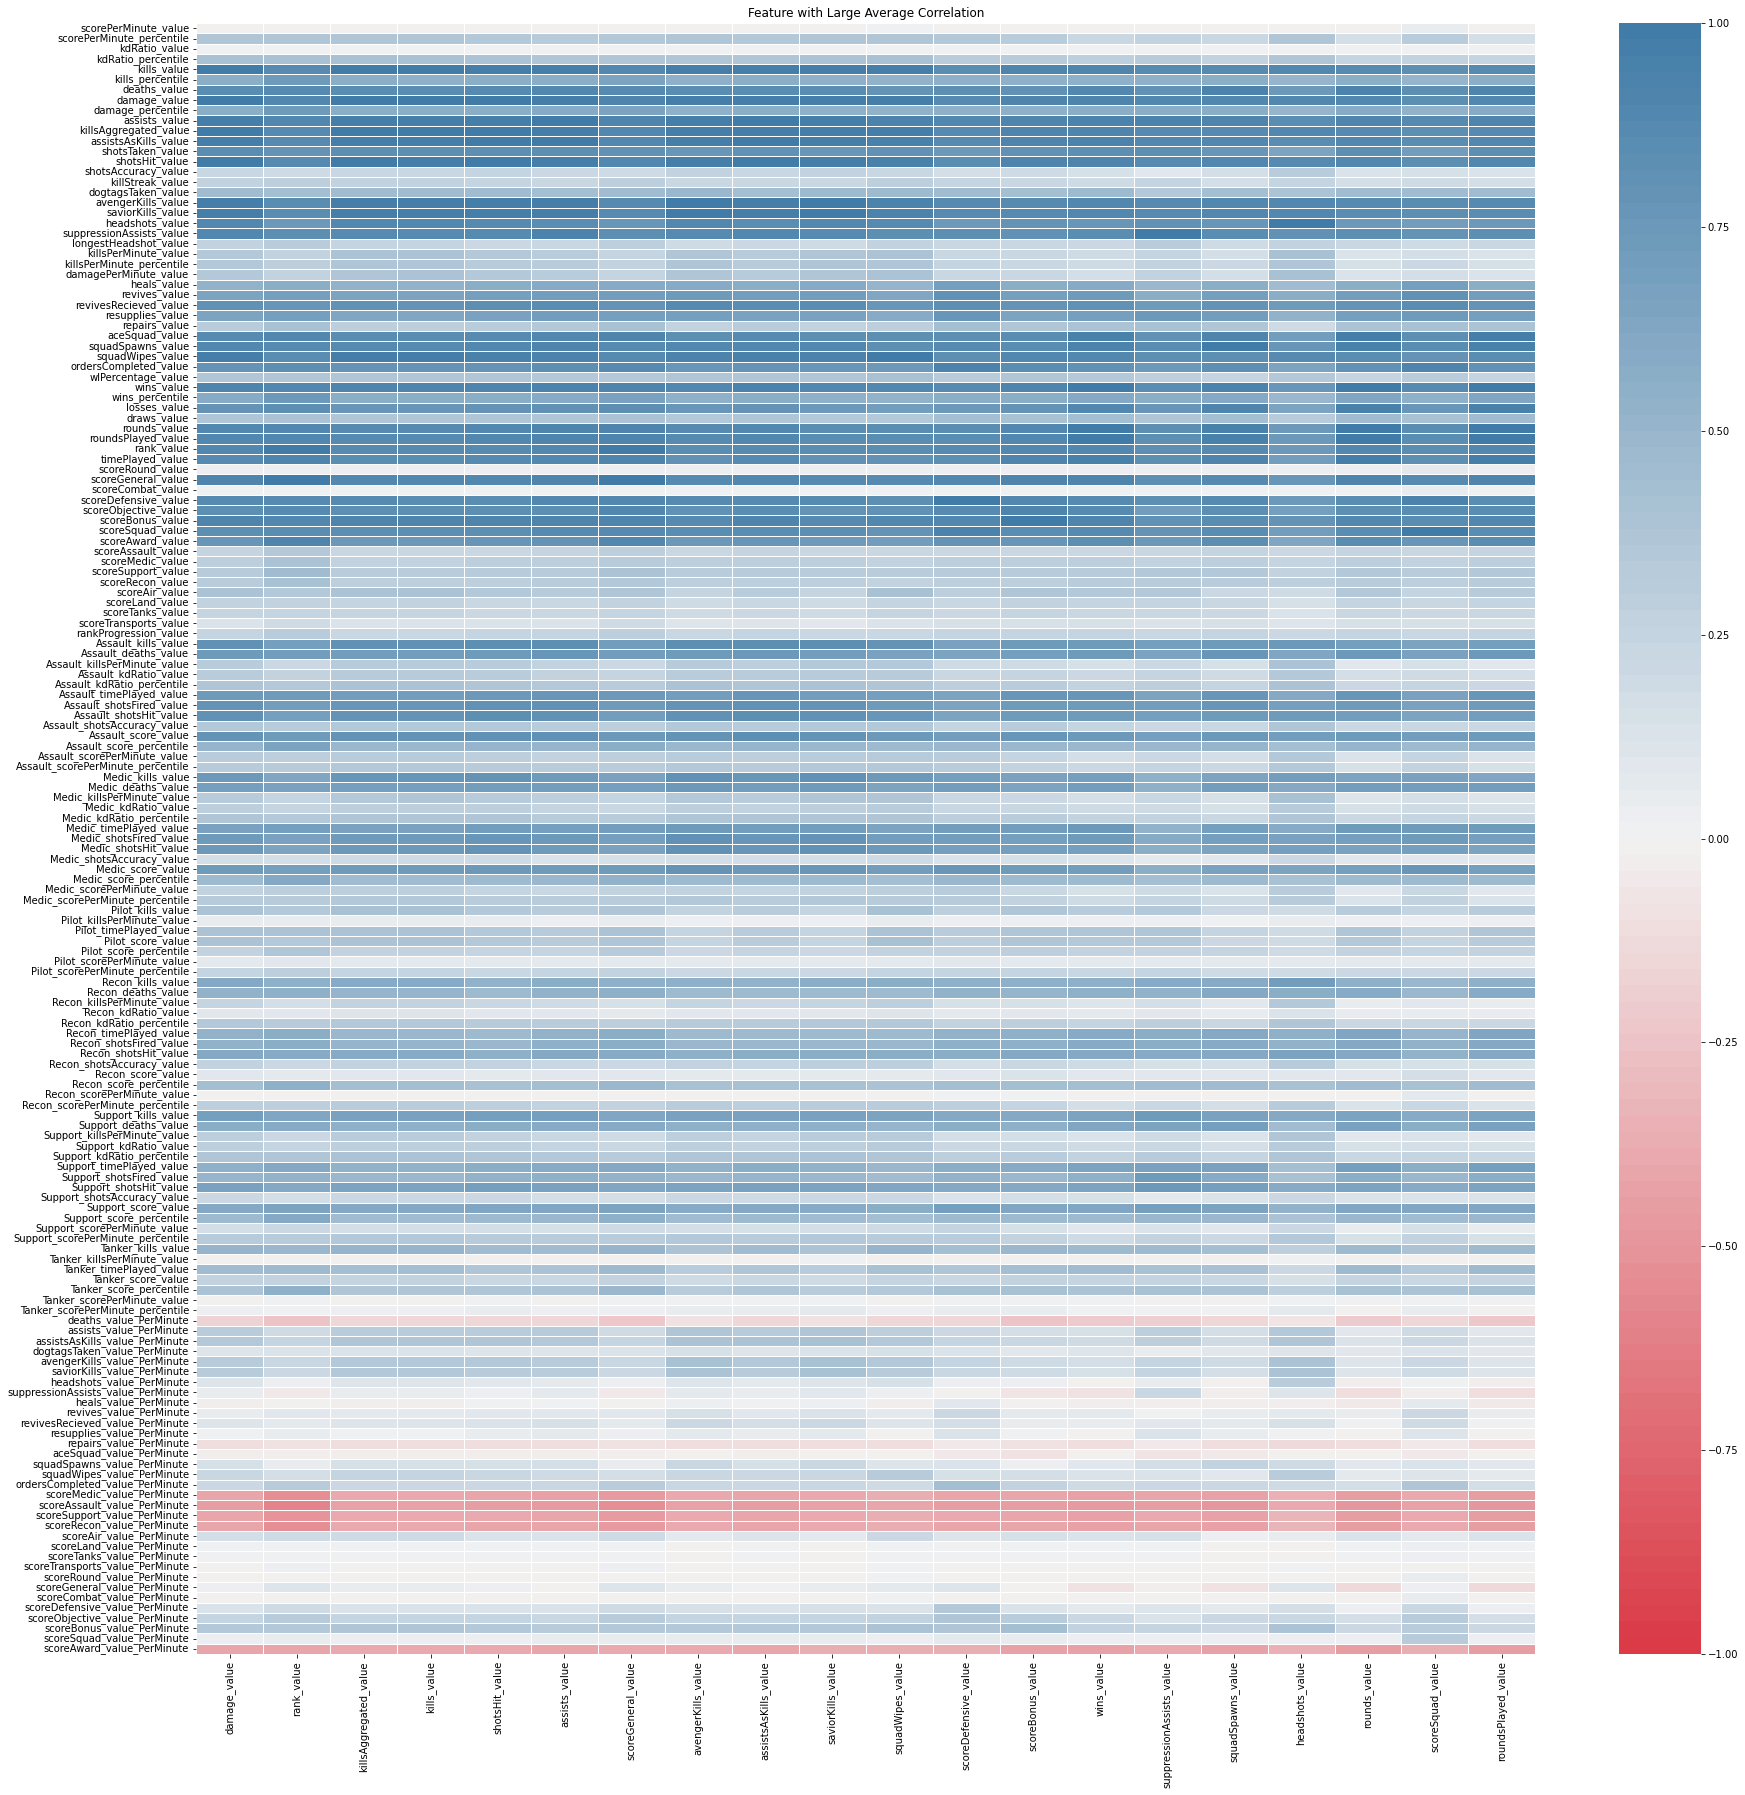

In [ ]:
plt.figure(figsize=(30,30))
plt.title('Feature with Large Average Correlation')
sns.heatmap(corr[large_corr_features], vmin=-1, vmax=1, cmap=cmap, linewidths=0.5)
plt.show()

Next the features with small correlations.

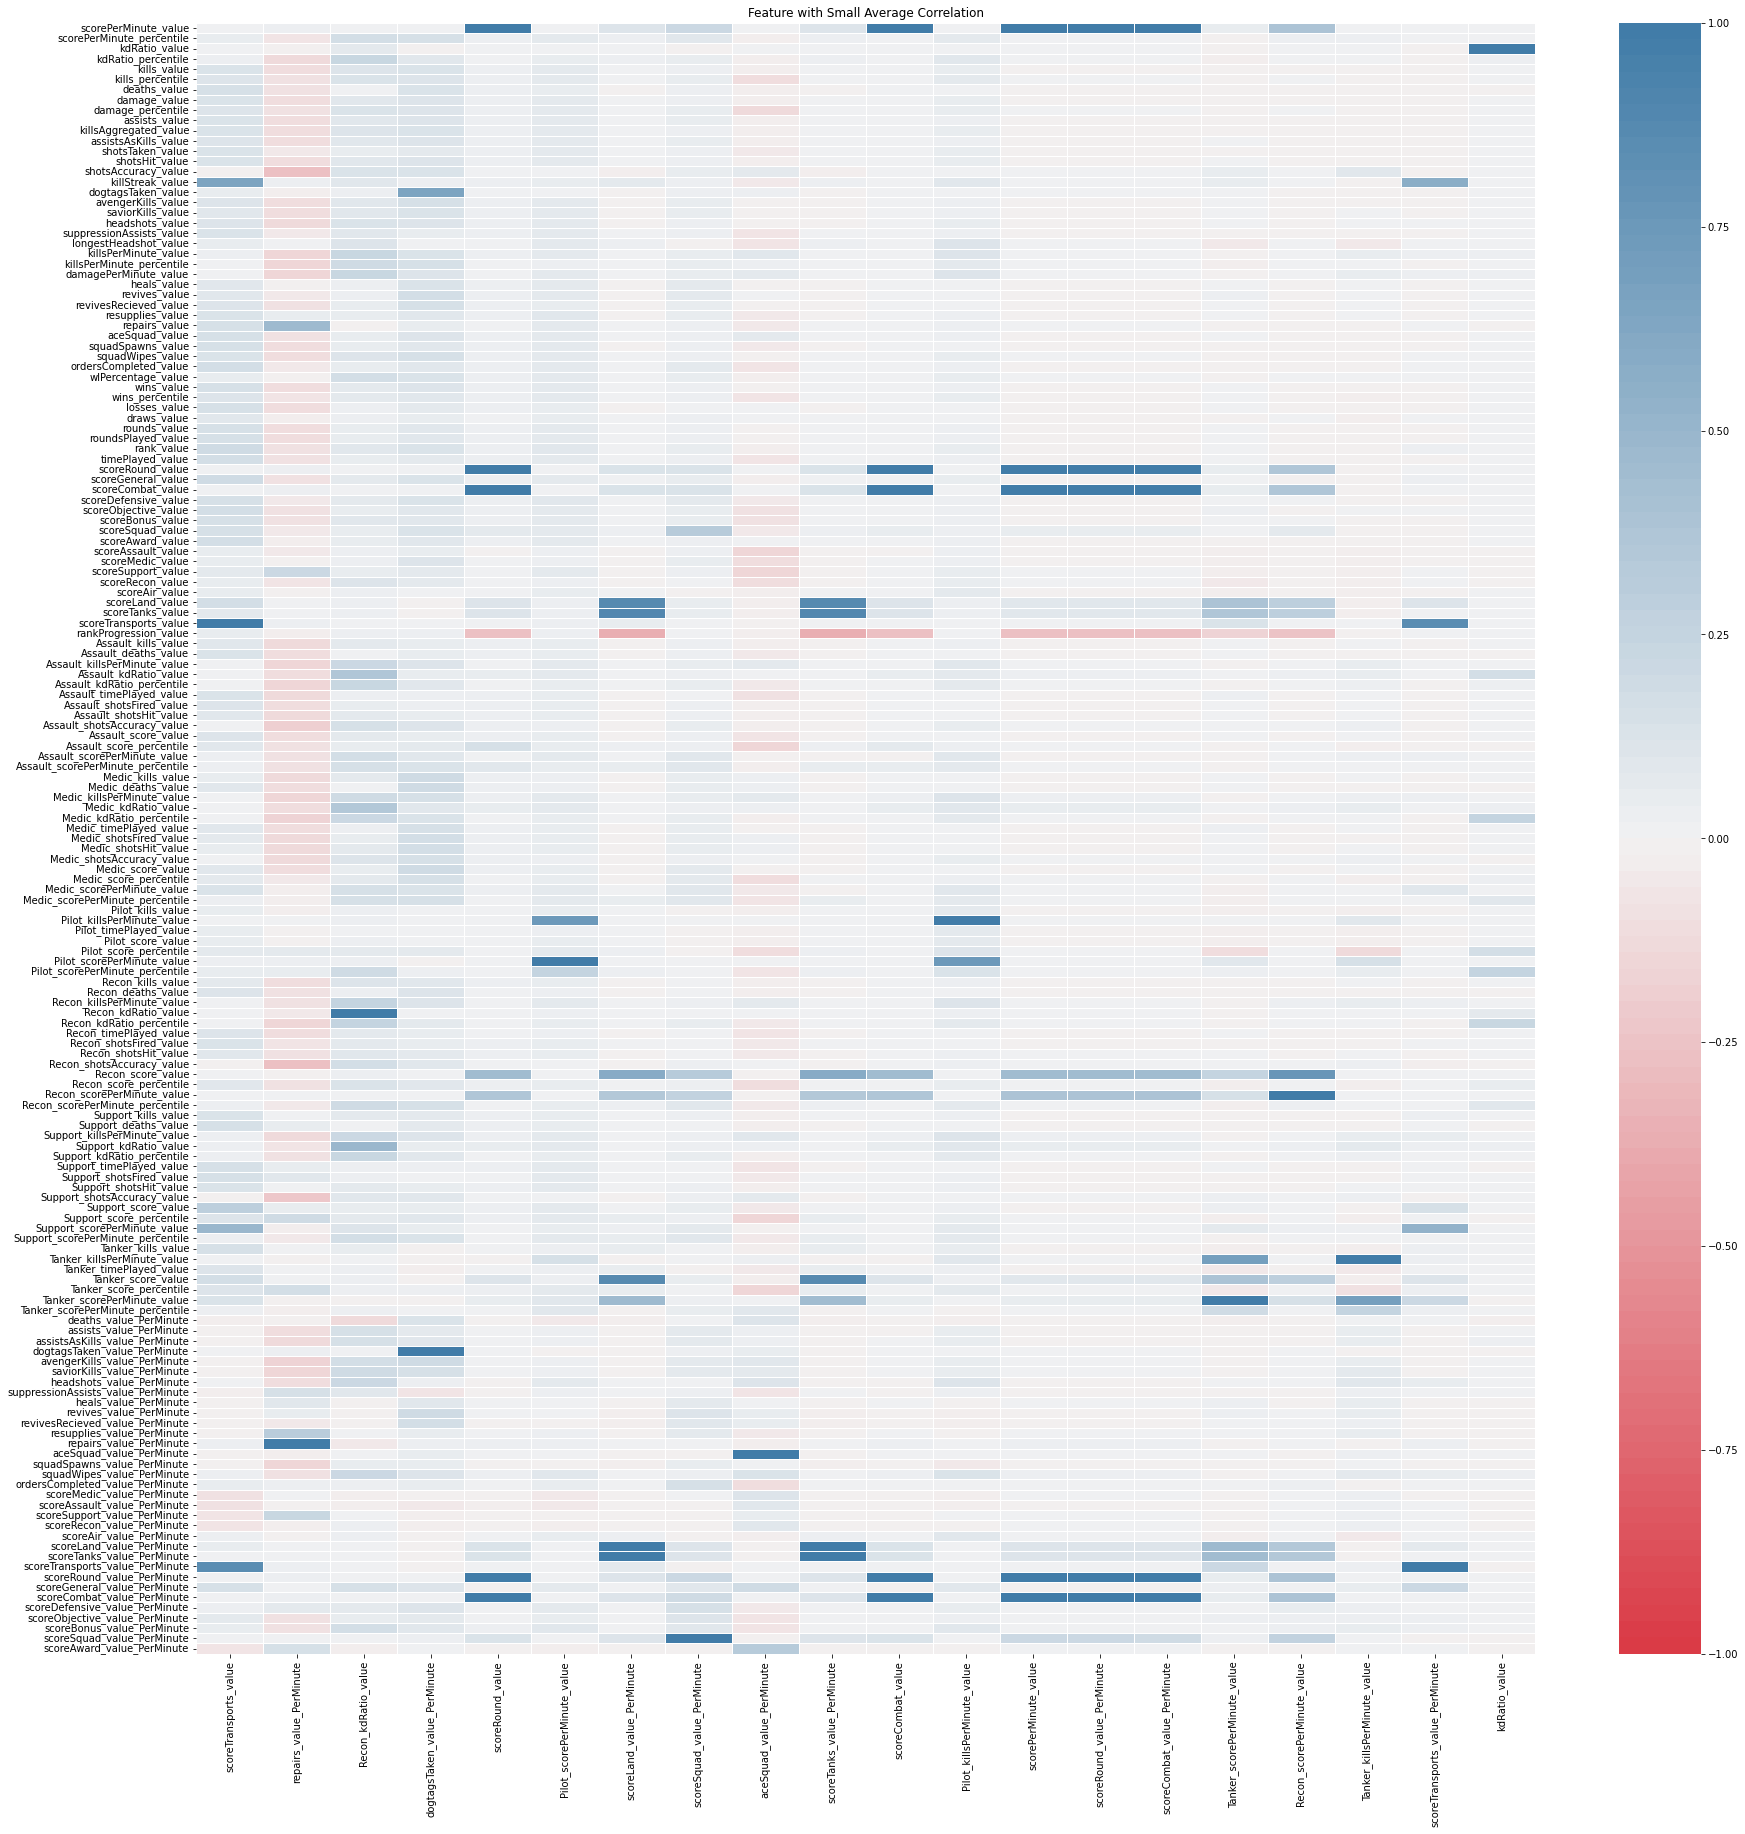

In [ ]:
plt.figure(figsize=(30,30))
plt.title('Feature with Small Average Correlation')
sns.heatmap(corr[small_corr_features], vmin=-1, vmax=1, cmap=cmap, linewidths=0.5)
plt.show()

## Outliers
The game has a known problem with cheaters, for example, people who use aimbots. I would prefer to remove these players from the dataset, as they are not representative of average players skills. I examine whether such players are in the dataset using basic statistical methods and domain knowledge. Given the fairly significant cheater problem in the game, I am fairly conservative at times.

One thing to note here is that raw values are going to be poor for detecting outliers by themselves. If I am terrible at the game but play 6 hours a day for years, I will likely have more kills than an excellent player who only plays 2 hours per week. However, they will likely have more kills per minute or kill death ratios. So when looking for outliers, I use features adjusted for time when possible.

Outlier detection will also be important for clustering. To cluster, I will be using KMeans. This algorithm computes cluster centers as the mean value of points in a cluster. The mean is sensetive to outliers (ex. consider the means of [1,2,3,4,5] and [1,2,3,1000,5]), thus KMeans will be sensitive to outliers. This of course does not mean that we can remove samples with a large value in a feature simply because the value is large.

### Medic and Assault Score per Minute
Note here the features are features for the score of the class averaged over total playtime, not score for the class averaged over playtime for the class.

In [ ]:
high_medic_support_score = df[(df['scoreAssault_value_PerMinute'] > 50) | (df['scoreMedic_value_PerMinute'] > 50)]
high_medic_support_score[['Medic_timePlayed_value', 'Assault_timePlayed_value', 'scoreAssault_value_PerMinute', 'scoreMedic_value_PerMinute']]

,Medic_timePlayed_value,Assault_timePlayed_value,scoreAssault_value_PerMinute,scoreMedic_value_PerMinute
5444,0.327778,3.937500,171.648000,15.586909
5945,23.408333,4.279167,154.699388,231.088288
25527,4.393056,3.473611,40.549051,96.604881
27047,7.736111,46.054167,70.749369,31.084914
34342,45.329167,54.240278,51.978631,51.978631
...,...,...,...,...
73546,6.491667,1.491667,14.974001,69.015534
73547,3.111111,22.150000,214.619829,32.394937
73548,0.983333,10.637500,109.361018,11.192450
73549,13.095833,9.350000,52.481069,98.039279


That value of score per minute is implausible and made even more so by the fact that it has only been achieved by 2 players with low playtimes in the classes for which their score per minute is high. Those samples are removed.

In [ ]:
df = df[(df['scoreAssault_value_PerMinute'] < 50) & (df['scoreMedic_value_PerMinute'] < 50)]

### Medic and Support Accuracy
Some players have accuracy values with the medic and support class greater than or equal to 100, which should be impossible. These players are examined then removed.

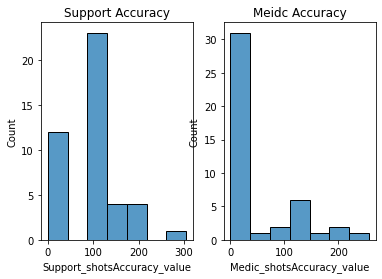

In [ ]:
high_accuracy = df[(df['Support_shotsAccuracy_value'] >= 100)  | (df['Medic_shotsAccuracy_value'] >= 100)]
fig, axes = plt.subplots(1, 2)

sns.histplot(df[(df['Support_shotsAccuracy_value'] >= 100)], x='Support_shotsAccuracy_value', ax=axes[0])
axes[0].set_title('Support Accuracy')

sns.histplot(df[(df['Medic_shotsAccuracy_value'] >= 100)], x='Medic_shotsAccuracy_value', ax=axes[1])
axes[1].set_title('Meidc Accuracy')
plt.show()

They are all dropped from the dataset.

In [ ]:
df = df[(df['Support_shotsAccuracy_value'] < 100)  & (df['Medic_shotsAccuracy_value'] < 100)]

### Class Kill Death Ratio
If asked, I would say that the player I know of with the best kill/death ratio has a kill/death ratio of about 5. This is an [outstanding player](https://battlefieldtracker.com/bfv/profile/psn/MaxiqYT/overview) with nearly 5000 hours played. They are essentially a minor celebrity for their kill/death ratio. So considering this as background, as well as general knowledge about Battlefield 5 specifically and FPS games in general, kill/death ratios of 6 or especially 7 and above strike me as essentially impossible to achieve with the so-called "infantry" classes in the game. One way this may be possible is if a player has a high k/d ratio for a class but low time playing the class. To examine the suspected outliers, I plot the kill/death ratio for each feature above a threshold of 6 against time played for the respective class.

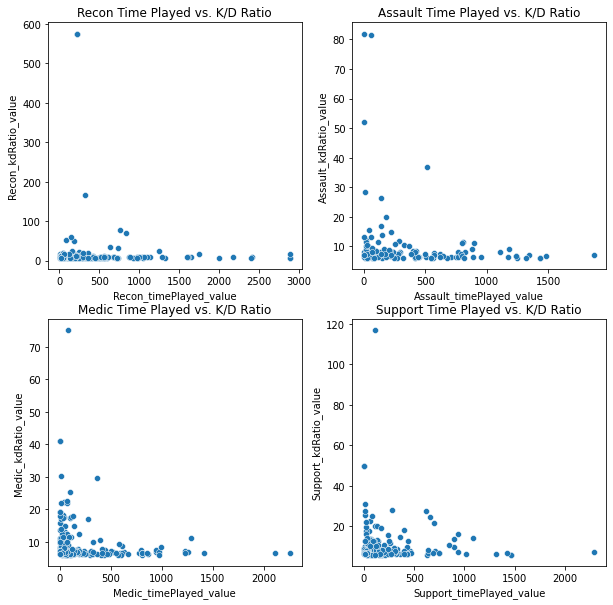

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
classes = ['Recon', 'Assault', 'Medic', 'Support']
for ax, infantry_class in zip(np.ravel(axes), classes):
    df_subset = df[df[f'{infantry_class}_kdRatio_value'] > 7][[f'{infantry_class}_timePlayed_value', f'{infantry_class}_kdRatio_value']]
    sns.scatterplot(data=df[df[f'{infantry_class}_kdRatio_value'] > 6], x=f'{infantry_class}_timePlayed_value', y=f'{infantry_class}_kdRatio_value', ax=ax)
    ax.set_title(f'{infantry_class} Time Played vs. K/D Ratio')

We see no strong relationship between time played for a various class and the kill/death ratio for the class. Further, noting that time played is given in hours, we also do not see the phenomena of a player having a very good kill/death ratio for a class but a very short time played for the class. As such, all of these outliers are removed.

In [ ]:
for infantry_class in classes:
    df = df[df[f'{infantry_class}_kdRatio_value'] < 7]

### Tank Score per Minute
The distribution of score per minute for tanks immediately stands out. I do not know much about vehicles in the game, but I know that 1M score per minute is essentially impossible, especially sustained over a long period of time. Additionally, it is easier to get kills with planes, but the score per minute distribution in planes is much more reasonable.

In [ ]:
tank_spm = df['Tanker_scorePerMinute_value']
tank_spm.describe()

count    5.254900e+04
mean     3.311603e+03
std      2.846642e+04
min      0.000000e+00
25%      4.409778e+02
50%      5.722273e+02
75%      9.714154e+02
max      2.463586e+06
Name: Tanker_scorePerMinute_value, dtype: float64

We can see here that most of the values are in the hundreds or low thousands, making the 1M score range value(s) look even more suspicious. To further examine them, I look only at values above the 3rd quartile.

In [ ]:
num_best_tankers = len(df[tank_spm > 10_000])
print(f'Only {num_best_tankers} have a score per minute in tanks over 10,000.')
tank_spm[tank_spm > np.quantile(tank_spm, q=0.75)].describe()

Only 2498 have a score per minute in tanks over 10,000.


count    1.313600e+04
mean     1.167447e+04
std      5.611160e+04
min      9.715676e+02
25%      1.411413e+03
50%      2.583437e+03
75%      6.920480e+03
max      2.463586e+06
Name: Tanker_scorePerMinute_value, dtype: float64

We can see here that the top 25% of the top 25% players with the highest score per minute in tanks would be outstanding to maintain a score perminute of 10,000. I feel confident in treating the players above that threshold as outliers.

In [ ]:
df = df[df['Tanker_scorePerMinute_value'] <= 10_000]

We can then revisualize the distribution of score per minute in tanks.

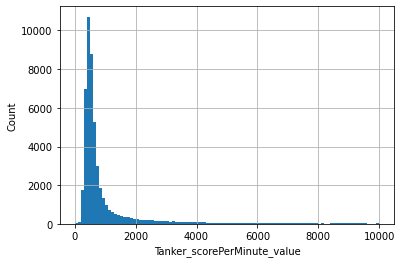

In [ ]:
df['Tanker_scorePerMinute_value'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Tanker_scorePerMinute_value')
plt.show()

This looks like what we expect based on the other plots.

#### Tank Kills per Minute
The tank kills per minute distribution also looks unusual. You can think of pilot kills per minute as a rough proxy for what the distribution for tanks should look like, except tank kills per minute should probably be lower. Getting hundreds of kills per minute is impossible for human players. Removing the score per minute outliers may have removed outliers in this feature, but it is best to check.

In [ ]:
df['Tanker_killsPerMinute_value'].describe()

count    50051.000000
mean         1.844198
std          2.542239
min          0.000000
25%          0.999685
50%          1.322287
75%          1.836153
max        350.875000
Name: Tanker_killsPerMinute_value, dtype: float64

We see above that there is still at least one implausible value, 119. A sustained value of 119 kills per minute with tanks is impossible. In most tanks a rate of fire of 1 shot per second would be high. In order to get a KPM of even 60 in a tank, one would have to get at kill every second with our hypothetical, high rate of fire weapon. This becomes impossible when you factor in just the time a player spends moving around the map and tank vs tank engagements. 

I check values over 20 to get a general idea of how much of an outlier the maximum value is.

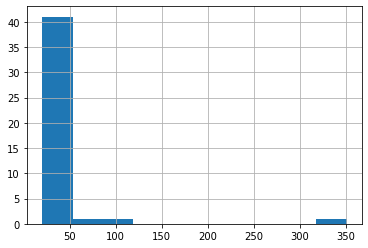

In [ ]:
df[df['Tanker_killsPerMinute_value'] > 20]['Tanker_killsPerMinute_value'].hist()
plt.show()

Due to the reasoning above, I remove values over 60 kills per minute.

In [ ]:
df = df[df['Tanker_killsPerMinute_value'] < 60]

### Tank Plots
Removing the outliers from the tank score per minute plots should have made them more readable, so I plot them again below.

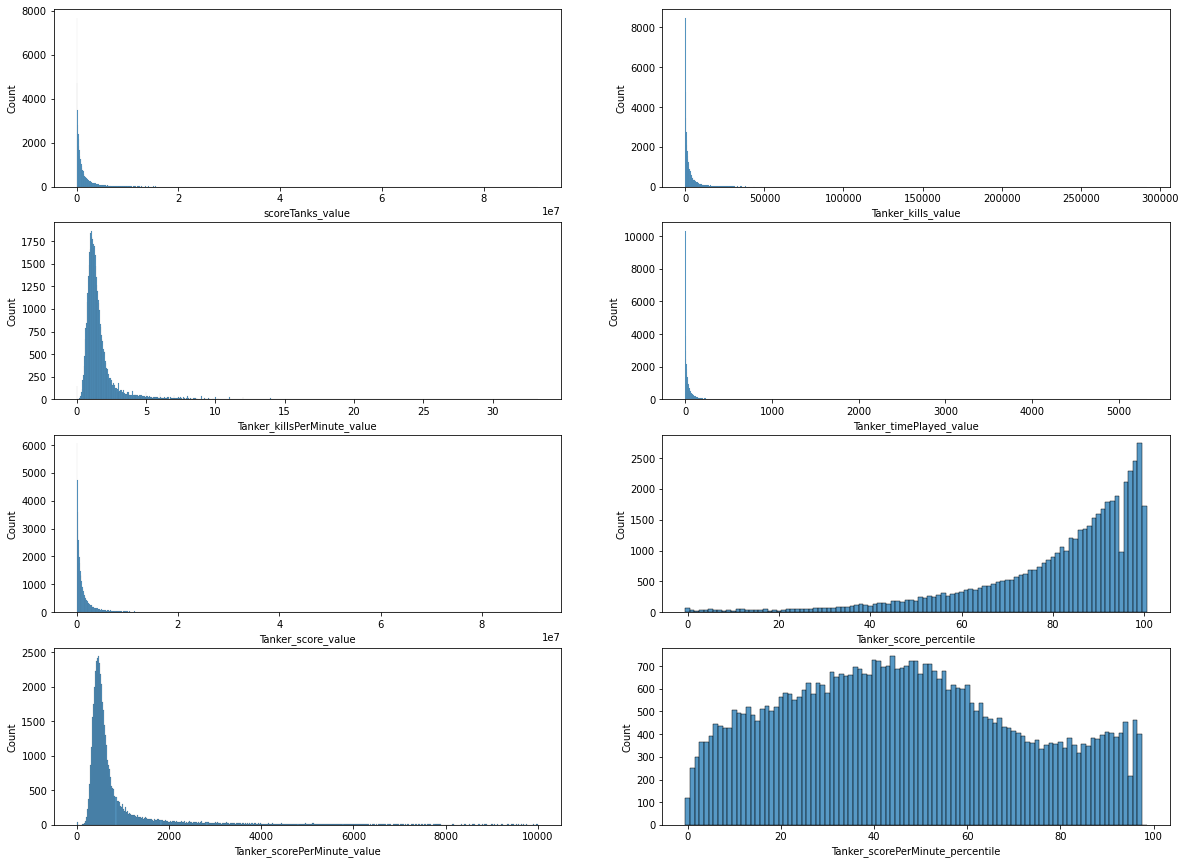

In [ ]:
tank_features = [feature for feature in df.columns if 'tank' in feature.lower()]
fig, axes = plt.subplots(4,2, figsize=(20,15))

for ax, feat in zip(np.ravel(axes), tank_features):
    if 'percentile' in feat.lower():
        sns.histplot(data=df[feat],ax=ax, discrete=True)
    else:
        sns.histplot(data=df[feat],ax=ax)

### Plane Kills Per Minute
The Pilot_killsPerMinute_value feature has at least one value of around 250 kills per minute. This value is impossible to achieve. It and any other outliers will be removed.

In [ ]:
df['Pilot_killsPerMinute_value'].describe()

count    50047.000000
mean         0.390767
std          2.614519
min          0.000000
25%          0.031250
50%          0.178571
75%          0.575213
max        467.000000
Name: Pilot_killsPerMinute_value, dtype: float64

We can see here that the maximum value really stands out, but I also check for other large values below.

In [ ]:
df[df['Pilot_killsPerMinute_value'] <= 5]['Pilot_killsPerMinute_value'].describe()

count    50000.000000
mean         0.357648
std          0.434720
min          0.000000
25%          0.031162
50%          0.178082
75%          0.573565
max          5.000000
Name: Pilot_killsPerMinute_value, dtype: float64

In [ ]:
df = df[df['Pilot_killsPerMinute_value'] < 5]

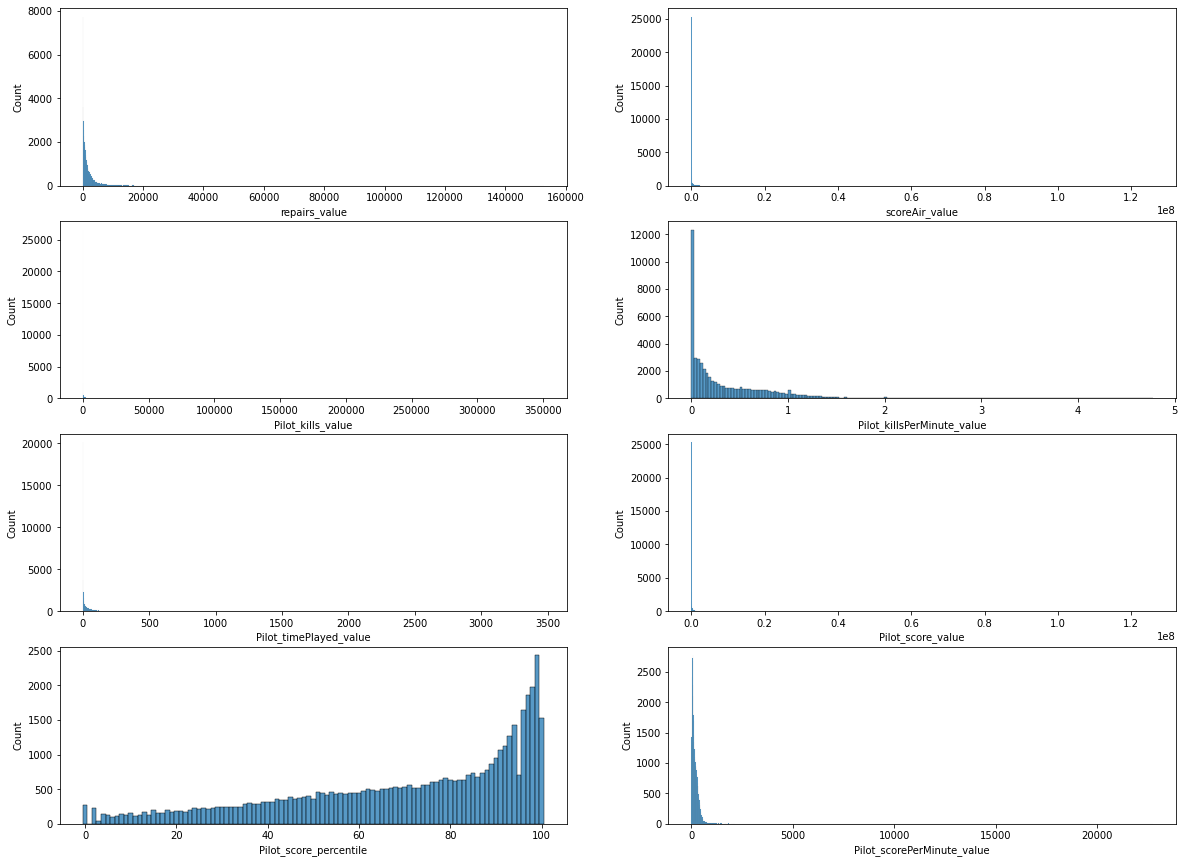

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(20,15))

for ax, feat in zip(np.ravel(axes), plane_features):
    if 'percentile' in feat.lower():
        sns.histplot(data=df[feat],ax=ax, discrete=True)
    else:
        sns.histplot(data=df[feat],ax=ax)
plt.show()

# Missing Values

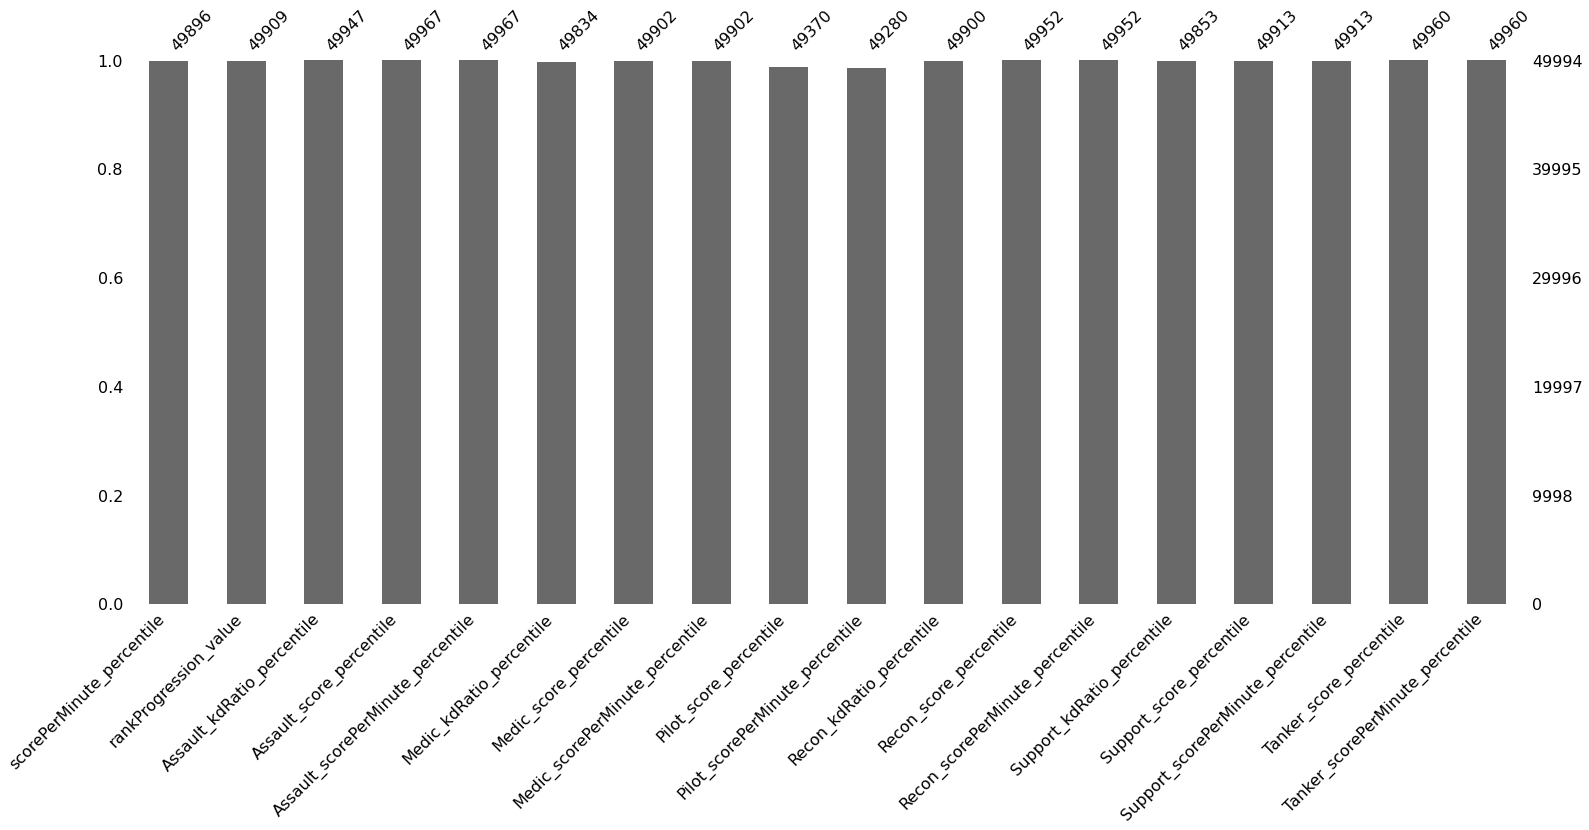

In [ ]:
features_with_nan = [feature for feature in df.columns if df[feature].isnull().sum() > 0]
missingno.bar(df[features_with_nan])
plt.show()

There are few enough features that I simply replace missing values with the mean value of the feature.

In [ ]:
df_imputed = df
for feature in features_with_nan:
    df_imputed[feature] = df[feature].fillna(df[feature].mean())

In [ ]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df_imputed[df.columns[2:]])

pca = PCA()
pca_features = pca.fit_transform(df_scaled)

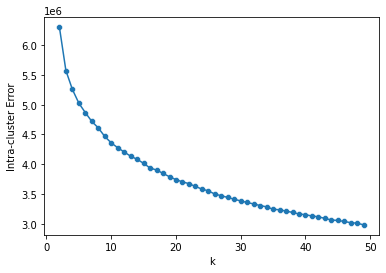

In [ ]:
k_range = range(2, 50)
sse = []

for k in k_range:
    kmeans = KMeans(random_state=123, n_clusters=k)
    kmeans.fit(pca_features)
    sse.append(kmeans.inertia_)

sns.lineplot(x=k_range, y=sse)
sns.scatterplot(x=k_range, y=sse)
plt.xlabel('k')
plt.ylabel('Intra-cluster Error')
plt.show()

<AxesSubplot:>

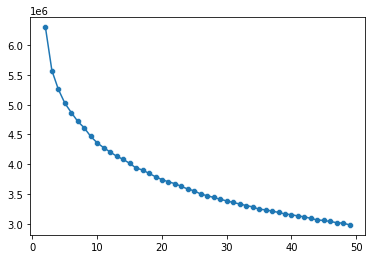

In [ ]:
sns.lineplot(x=k_range, y=sse)
sns.scatterplot(x=k_range, y=sse)

In [ ]:
k=5
kmeans = KMeans(random_state=123, n_clusters=k)
kmeans.fit(df_scaled)
clusters = kmeans.labels_

In [ ]:
pcs = [f'pc_{i+1}' for i in range(pca_features.shape[1])]
df_pca = pd.DataFrame(pca_features, columns=pcs)

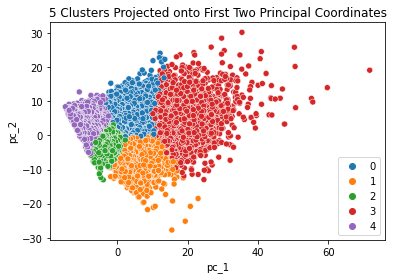

In [ ]:

sns.scatterplot(data=df_pca, x='pc_1', y='pc_2', hue=clusters, palette='tab10')
plt.title(f'{k} Clusters Projected onto First Two Principal Coordinates')
plt.show()

## Analyzing Features by Cluster

In [ ]:
def plot_cluster_stats(features, num_x_plots, num_y_plots, height=25, width=25):
    df_subset = df[features+['clusters']].groupby('clusters').agg(['mean', 'std'])
    fig, axes = plt.subplots(num_y_plots, num_x_plots, figsize=(width, height))
    clusters = np.array(range(1, k+1))
    for feature, ax in zip(features, np.ravel(axes)):
        # Plot means
        ax.bar(x=clusters - 0.2, height=df_subset[feature]['mean'], width=0.4)

        # Plot standard deviations
        ax.bar(x=clusters + 0.2, height=df_subset[feature]['std'], width=0.4)

        ax.set_title(feature)
        ax.set_xlabel('Cluster')

    for i, ax in enumerate(np.ravel(axes)):
        if i > len(features)-1:
            ax.axis('off')
    plt.show()

df['clusters'] = kmeans.labels_

### General Features

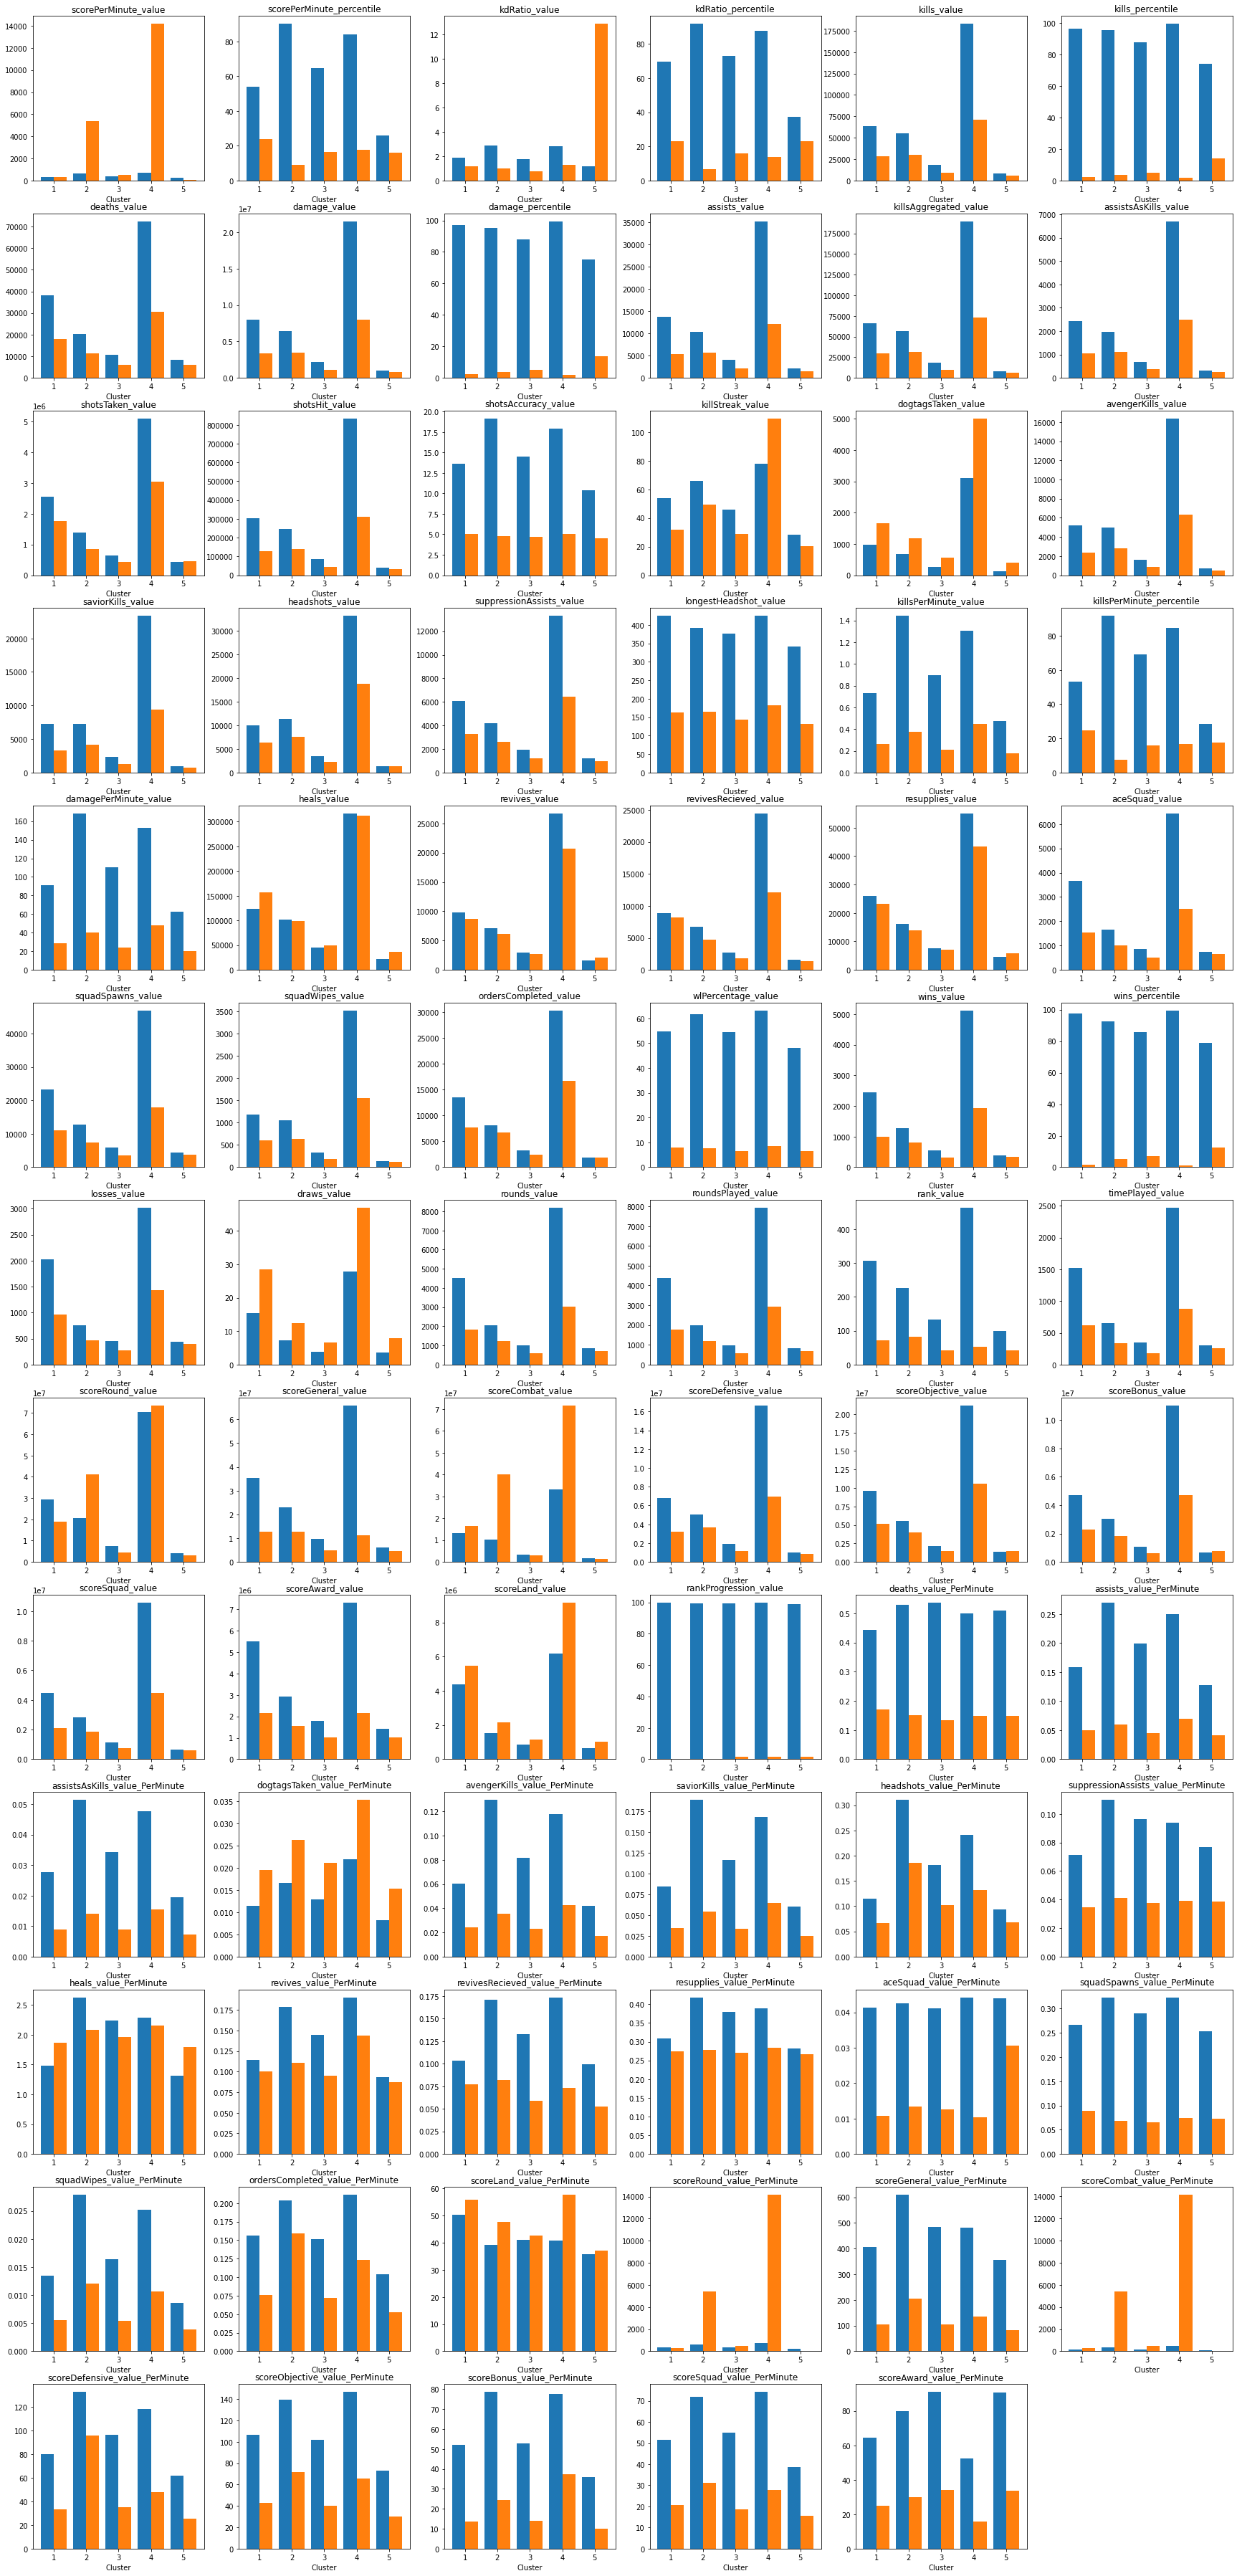

In [ ]:
plot_cluster_stats(general_features[1:], 6, 13, height=65, width=30)

### Medic Features

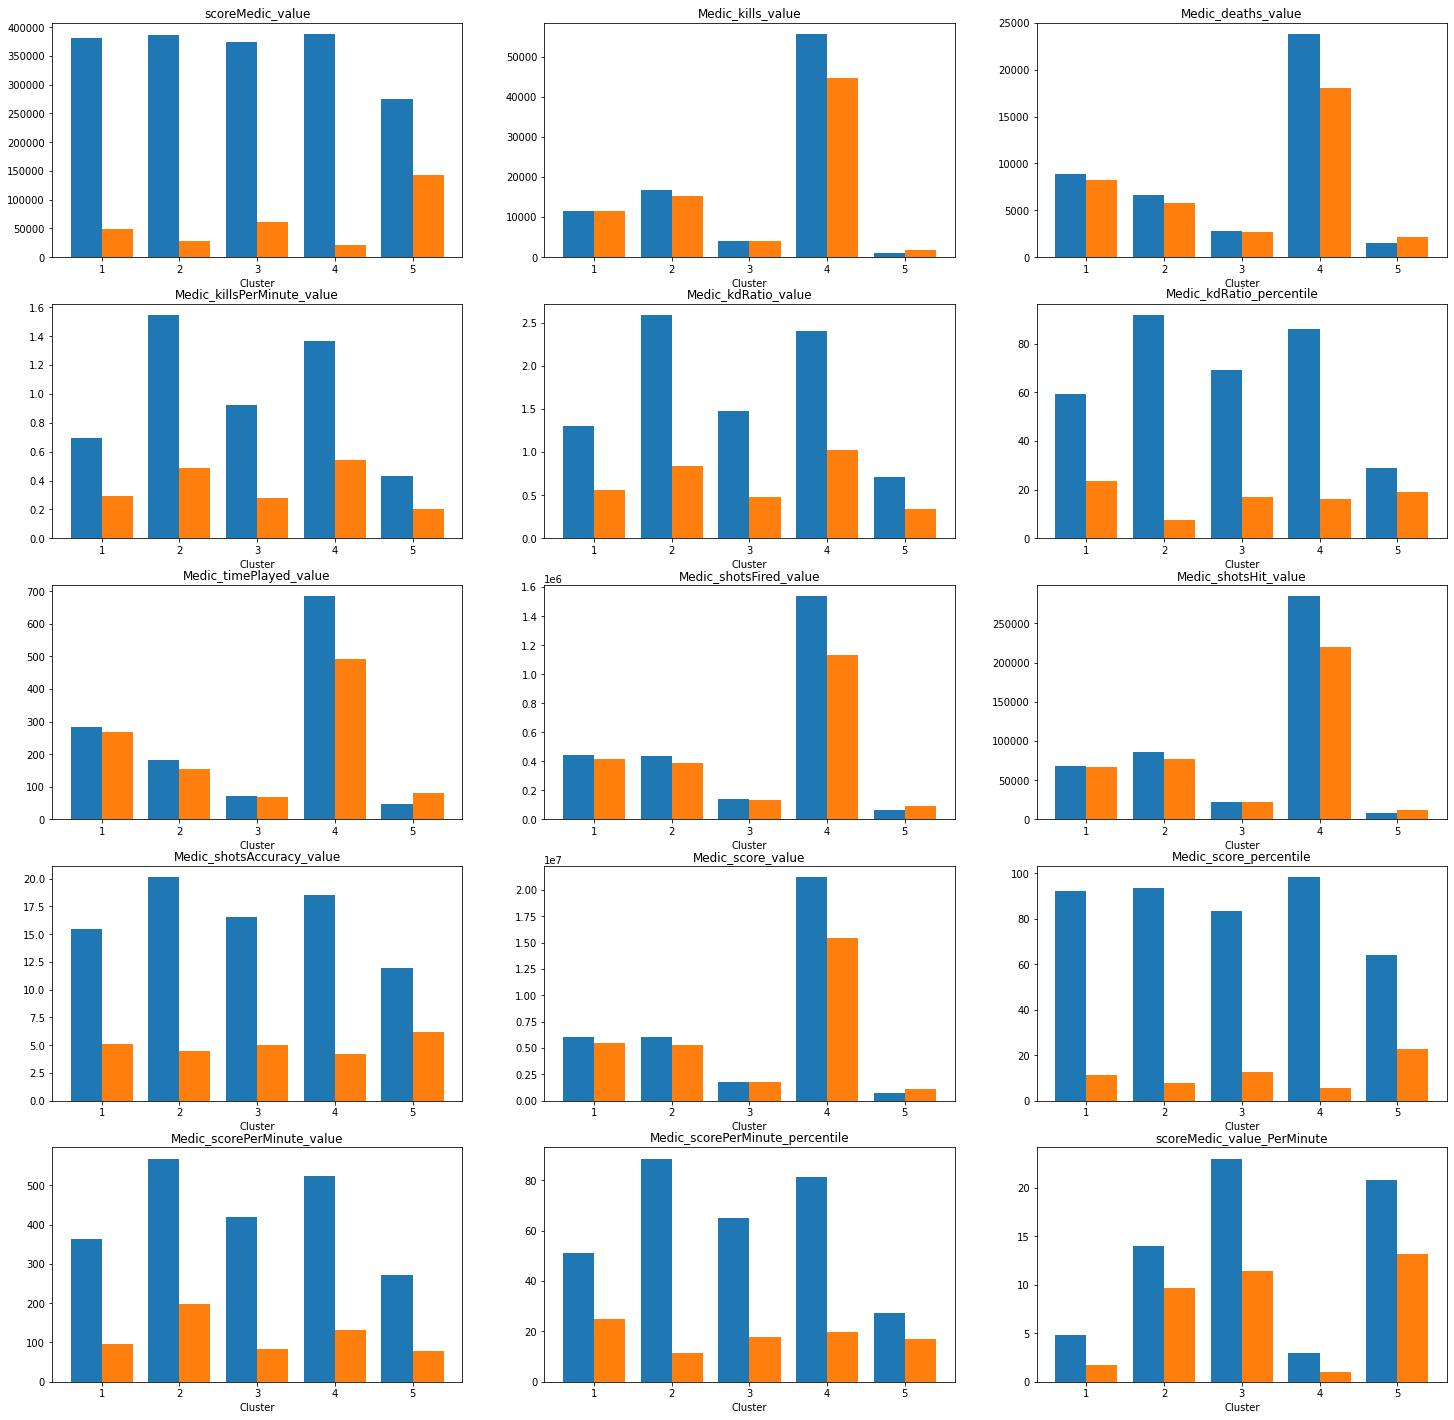

In [ ]:
plot_cluster_stats(medic_features, 3, 5)

### Assault Features

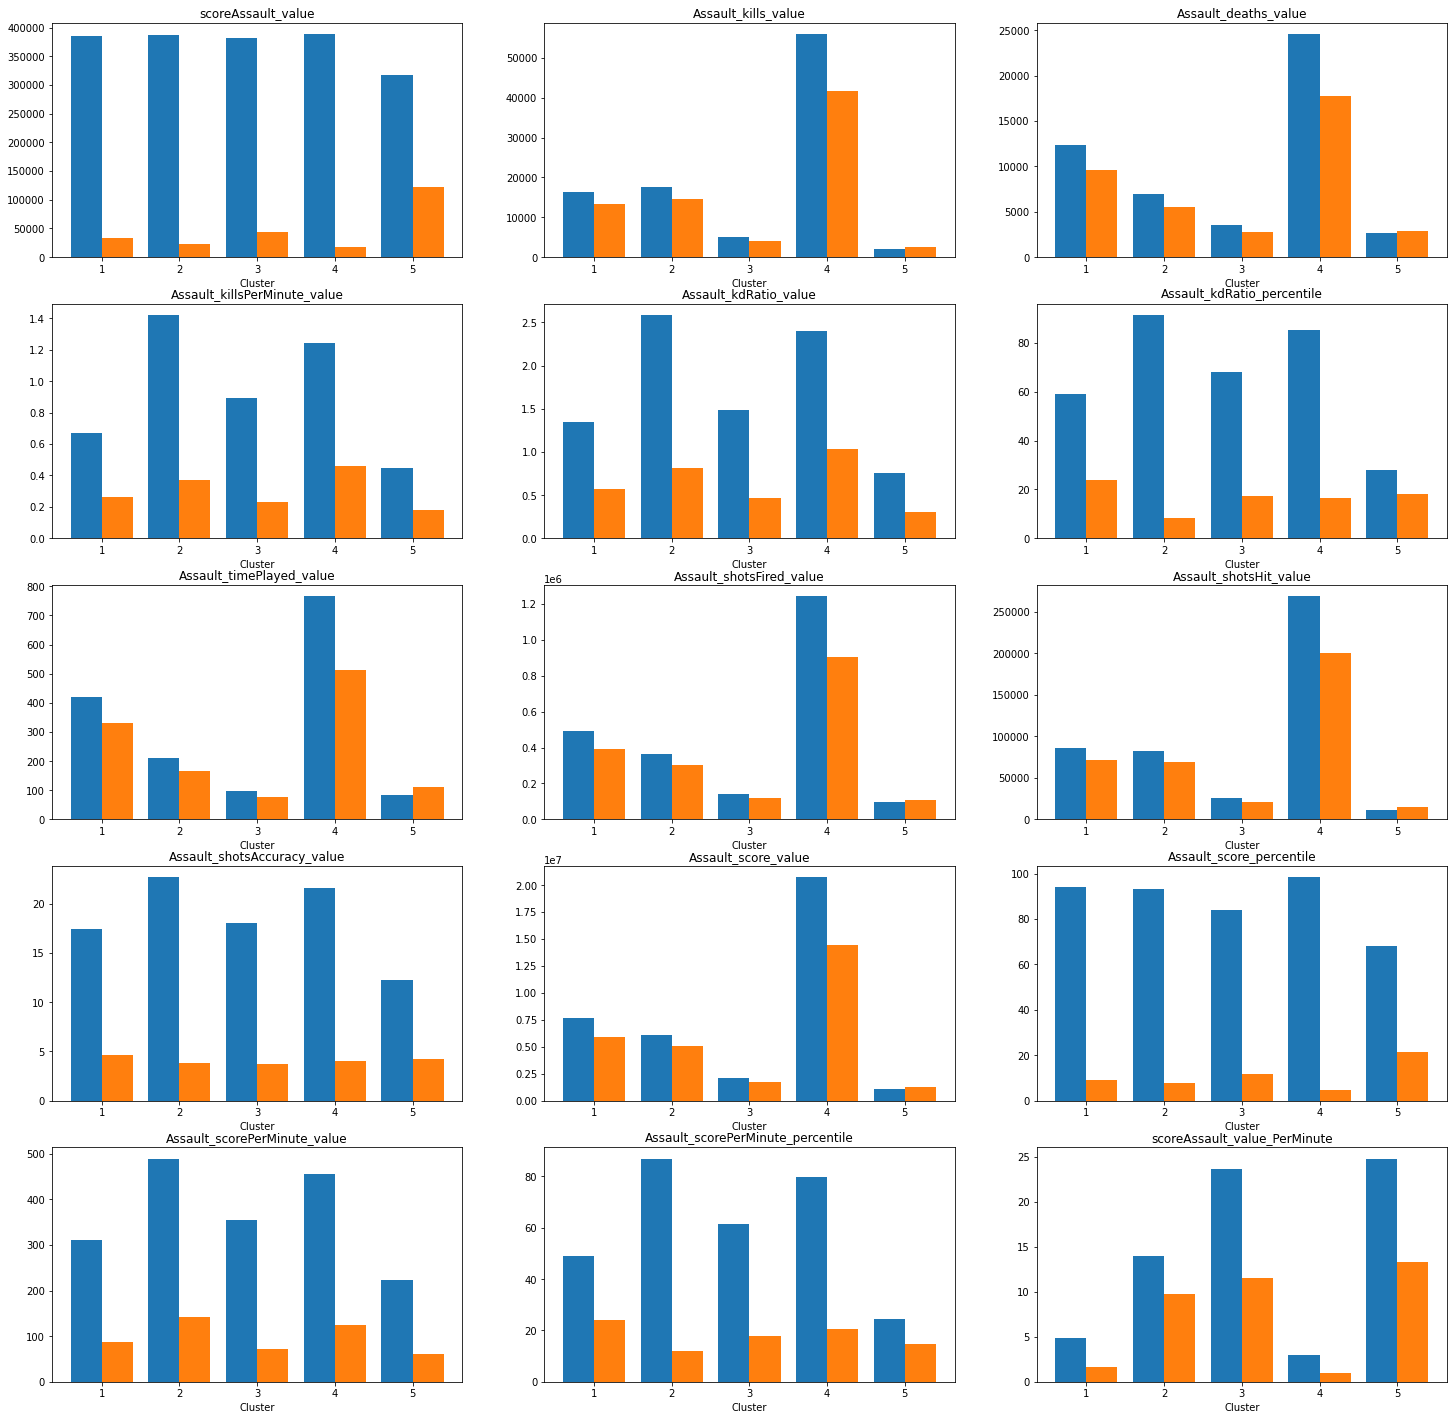

In [ ]:
plot_cluster_stats(assault_features, 3, 5)

### Support Features

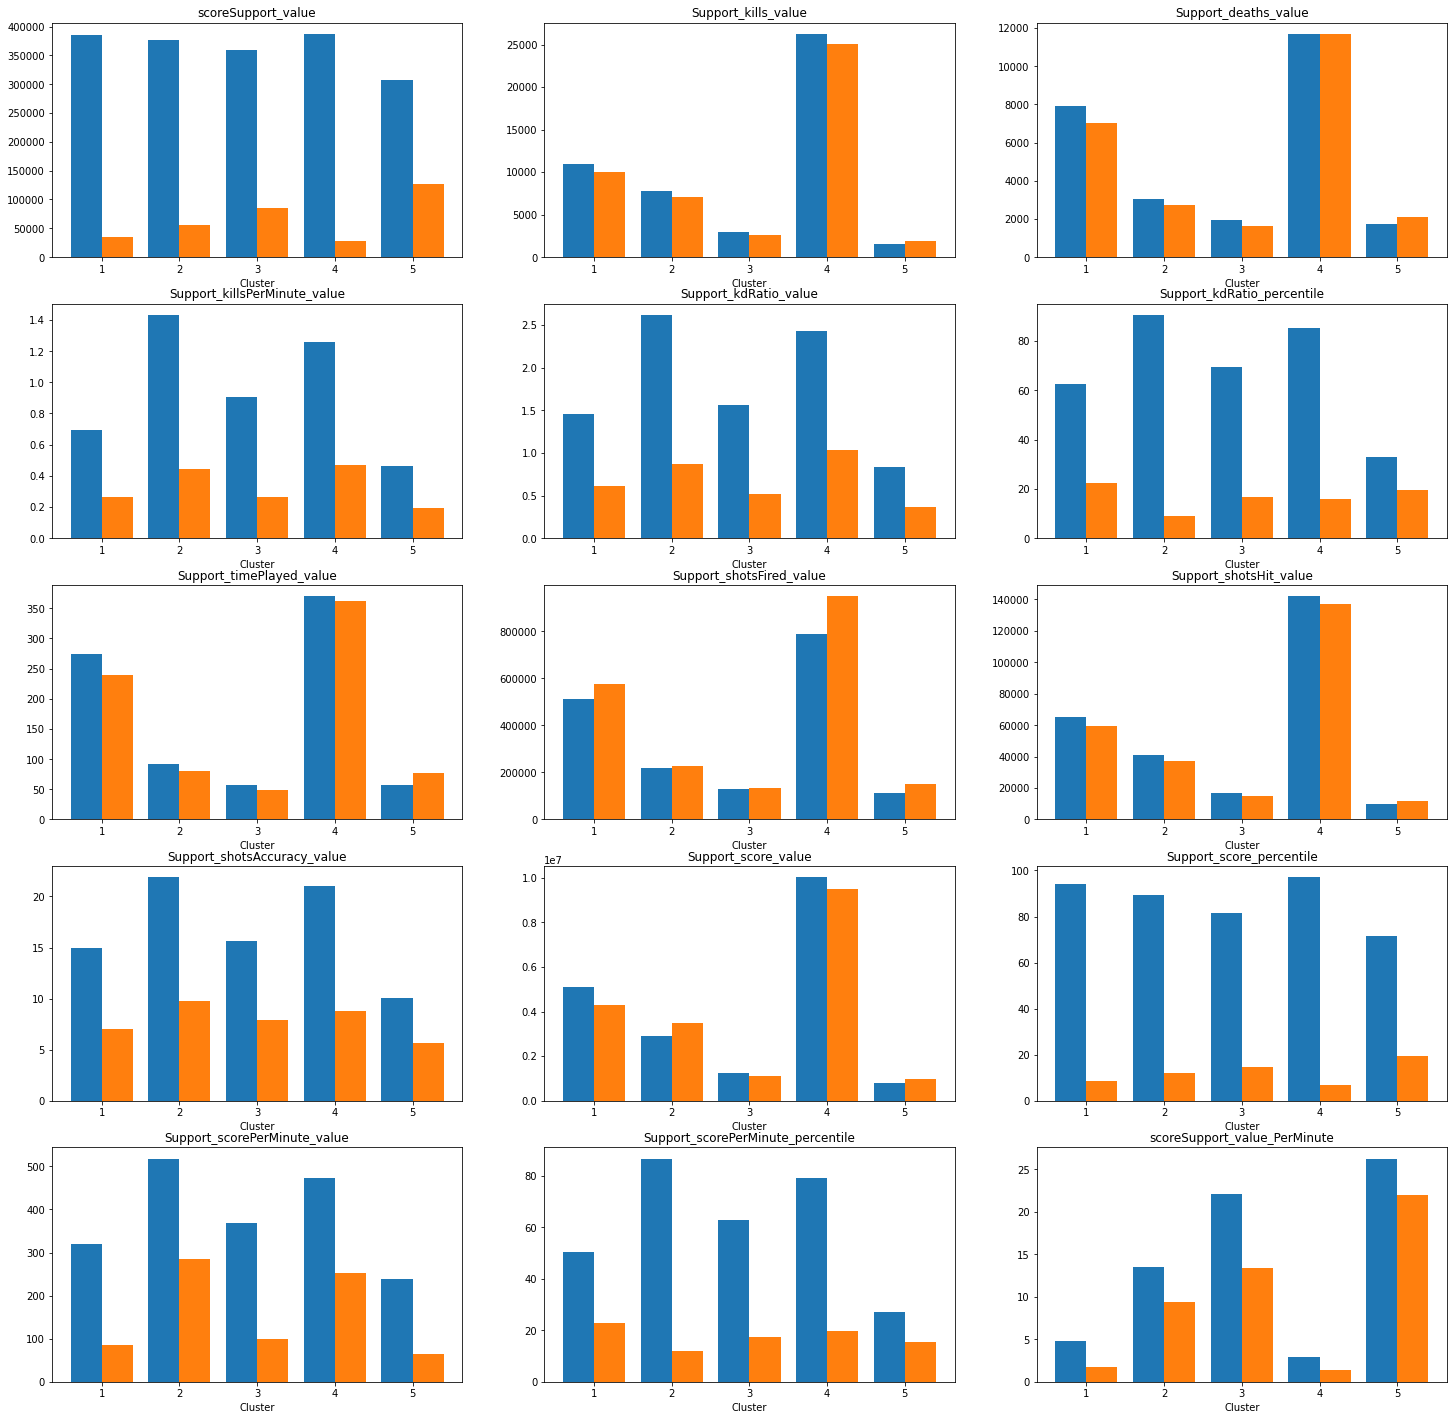

In [ ]:
plot_cluster_stats(support_features, 3, 5)

### Recon Features

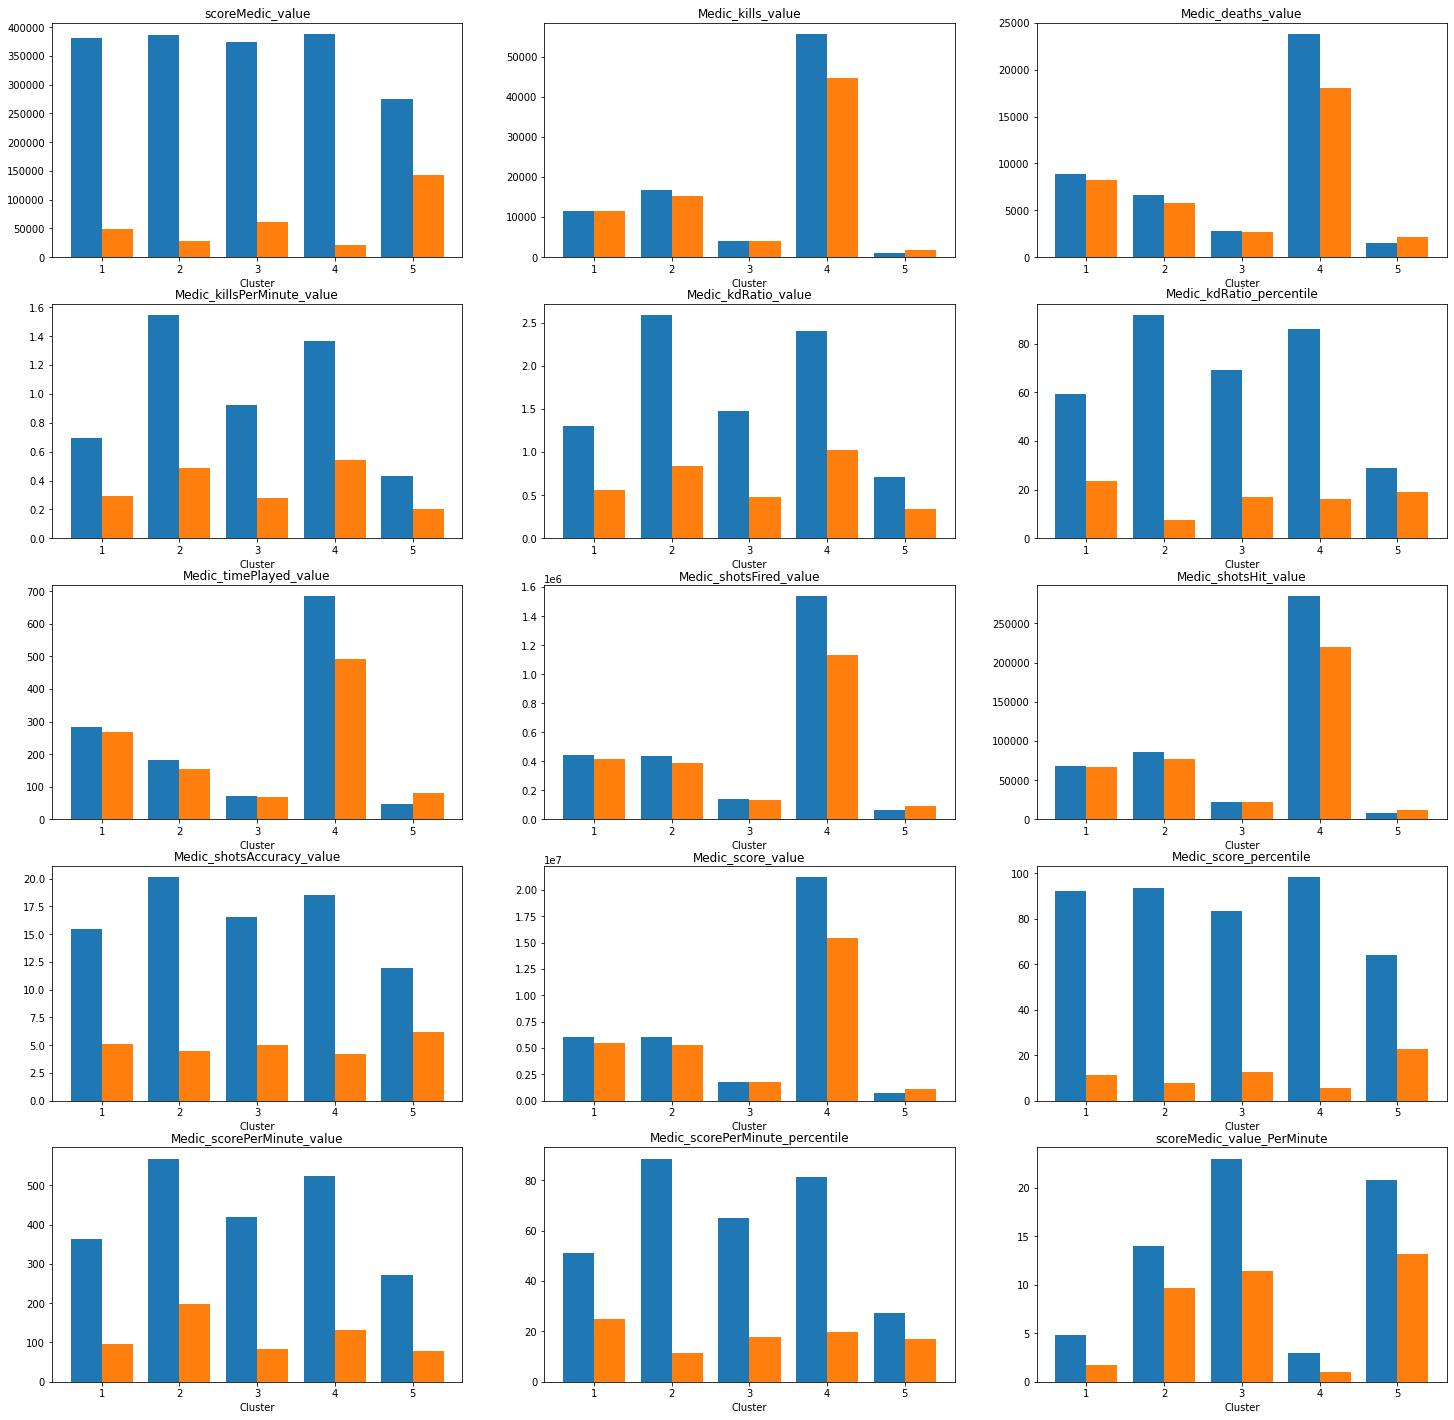

In [ ]:
plot_cluster_stats(medic_features, 3, 5)

## Ground Vehicle Features

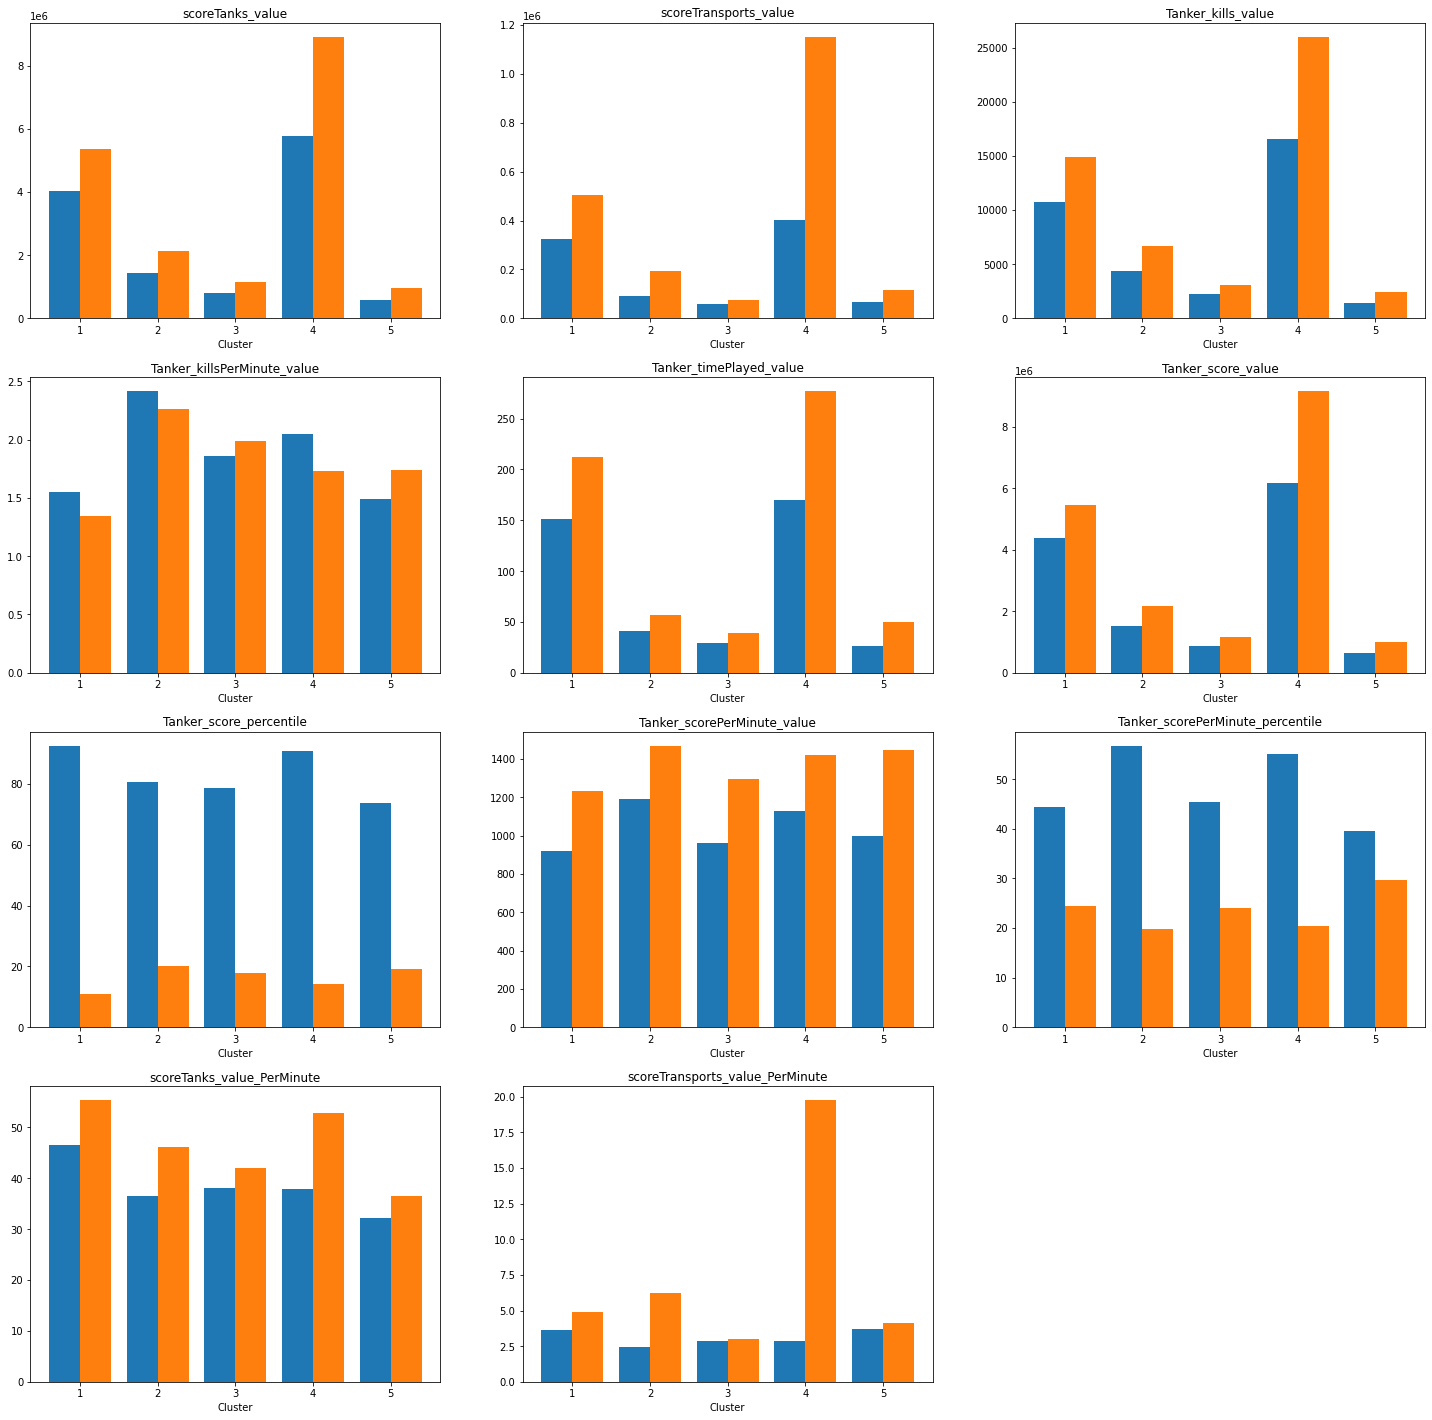

In [ ]:
plot_cluster_stats(ground_vehicle_features, 3, 4)

### Plane Features

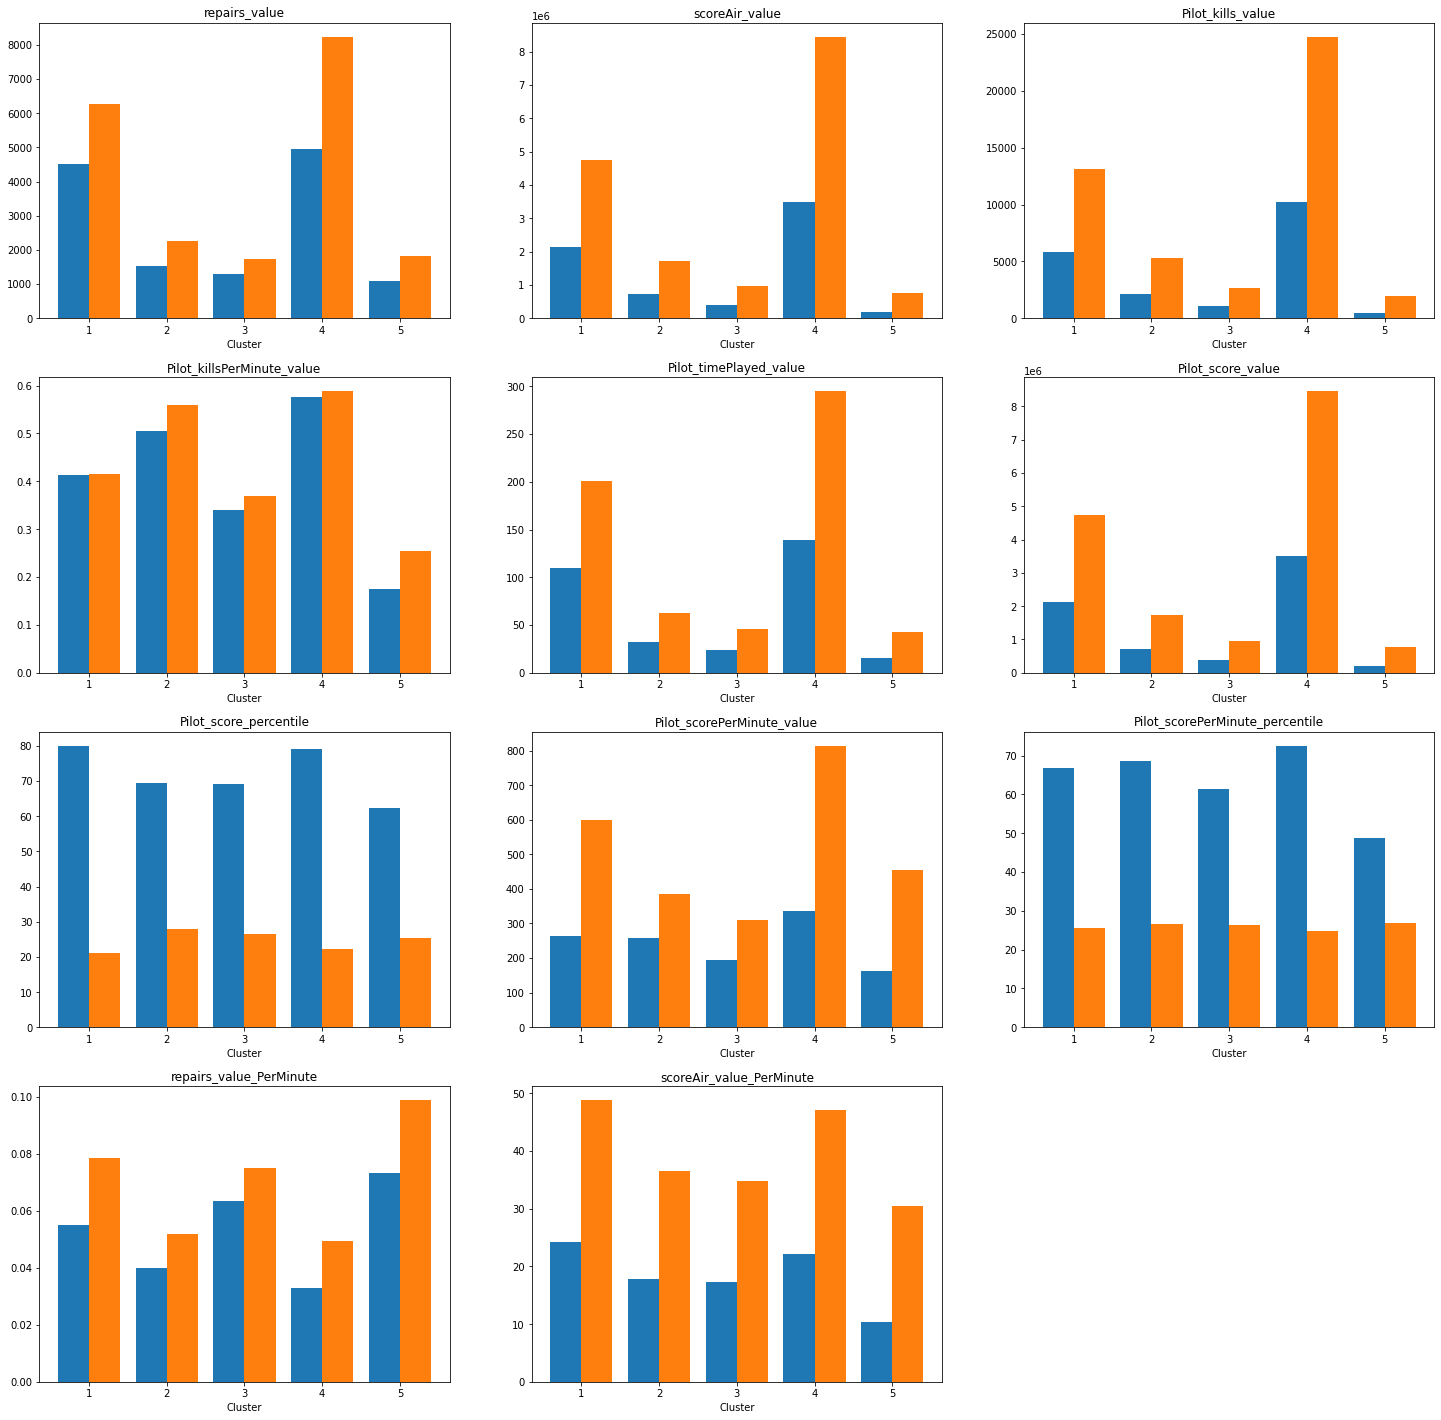

In [ ]:
plot_cluster_stats(plane_features, 3, 4)

In [ ]:
df['clusters'] = kmeans.labels_
df_cluster_summary = df.groupby('clusters').agg(['mean', 'std'])
df_cluster_summary

C:\Users\Patrick\AppData\Local\Temp\ipykernel_32924\1938406920.py:2: FutureWarning: ['platform'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_cluster_summary = df.groupby('clusters').agg(['mean', 'std'])


scorePerMinute_value               scorePerMinute_percentile  \
                         mean           std                      mean   
clusters                                                                
0                  335.445088    315.519193                 54.018419   
1                  617.542918   5389.766191                 90.057912   
2                  371.246234    476.858333                 64.718318   
3                  727.015094  14175.498421                 84.096162   
4                  237.011119     58.841575                 26.074518   

                    kdRatio_value            kdRatio_percentile             \
                std          mean        std               mean        std   
clusters                                                                     
0         23.993934      1.877999   1.191277          69.556542  22.843468   
1          9.070346      2.890524   0.999706          91.776699   6.776005   
2         16.314040      1.786972   0.773501          73.078240  15.860992   
3         17.627183      2.826673   1.309719          87.648012  13.823217   
4         15.855813      1.152407  12.888651          37.501176  22.915217   

            kills_value                ... scoreDefensive_value_PerMinute  \
                   mean           std  ...                           mean   
clusters                               ...                                  
0          63379.183805  28679.410313  ...                      79.715881   
1          54817.749106  30133.584172  ...                     132.569124   
2          18028.496314   9356.815310  ...                      96.137462   
3         183016.172281  71090.173414  ...                     118.032784   
4           7852.416913   6053.110691  ...                      61.985491   

                    scoreObjective_value_PerMinute             \
                std                           mean        std   
clusters                                                        
0         33.126137                     106.570885  42.749966   
1         95.794843                     139.226652  71.971756   
2         34.800286                     101.985782  39.825471   
3         47.770128                     146.737748  65.998820   
4         25.138772                      73.088880  30.134134   

         scoreBonus_value_PerMinute            scoreSquad_value_PerMinute  \
                               mean        std                       mean   
clusters                                                                    
0                         52.121265  13.417290                  51.432186   
1                         78.600833  24.295947                  71.822575   
2                         52.839575  13.845200                  54.940254   
3                         77.459319  37.367021                  74.203950   
4                         35.718961   9.879372                  38.792855   

                    scoreAward_value_PerMinute             
                std                       mean        std  
clusters                                                   
0         20.490928                  64.448324  24.812778  
1         31.339565                  79.702411  29.947129  
2         18.491596                  90.991424  34.127688  
3         27.921754                  52.246552  15.710793  
4         15.411416                  90.510964  33.663487  

[5 rows x 318 columns]

In [ ]:
df[medic_features+['clusters']].groupby('clusters').agg(['mean', 'std'])

scoreMedic_value                Medic_kills_value                \
                     mean            std              mean           std   
clusters                                                                   
0           380955.826093   49561.685425      11547.092416  11558.240403   
1           386875.321754   28046.762062      16671.969994  15258.363191   
2           374245.666423   60819.319489       3985.548928   3988.688819   
3           388437.762286   20558.065918      55766.866648  44825.981221   
4           275324.518509  142272.369068       1150.413376   1672.510846   

         Medic_deaths_value               Medic_killsPerMinute_value  \
                       mean           std                       mean   
clusters                                                               
0               8832.302956   8182.355096                   0.698146   
1               6597.845701   5771.578776                   1.545949   
2               2739.025547   2655.151604                   0.926216   
3              23812.571507  18060.632990                   1.365978   
4               1552.515630   2114.532268                   0.433657   

                   Medic_kdRatio_value            ... Medic_score_value  \
               std                mean       std  ...              mean   
clusters                                          ...                     
0         0.291973            1.301460  0.554453  ...      6.003577e+06   
1         0.483783            2.587563  0.835453  ...      6.023786e+06   
2         0.279722            1.480385  0.480647  ...      1.799793e+06   
3         0.540439            2.408503  1.018948  ...      2.118502e+07   
4         0.201228            0.715876  0.338019  ...      7.564756e+05   

                       Medic_score_percentile             \
                   std                   mean        std   
clusters                                                   
0         5.517743e+06              91.962382  11.464712   
1         5.270762e+06              93.394693   7.844898   
2         1.727872e+06              83.410492  12.603712   
3         1.539407e+07              98.128078   5.357271   
4         1.149726e+06              64.160215  22.778557   

         Medic_scorePerMinute_value              \
                               mean         std   
clusters                                          
0                        363.410777   96.844500   
1                        567.492720  198.599996   
2                        419.339591   83.612128   
3                        523.541918  132.479175   
4                        271.712502   78.422042   

         Medic_scorePerMinute_percentile             \
                                    mean        std   
clusters                                              
0                              50.944361  24.797911   
1                              88.607463  11.371790   
2                              65.152251  17.771557   
3                              81.459194  19.960579   
4                              27.499338  16.888642   

         scoreMedic_value_PerMinute             
                               mean        std  
clusters                                        
0                          4.775842   1.742247  
1                         13.956015   9.669156  
2                         22.978198  11.436093  
3                          2.930190   1.010071  
4                         20.807113  13.176613  

[5 rows x 30 columns]

In [ ]:
df.groupby(['clusters']).count()['Medic_kills_value']

clusters
0     7780
1     8665
2    17771
3     3622
4    12156
Name: Medic_kills_value, dtype: int64